# Матчинг товаров

## Вводные

**Описание задачи**:  
Неободимо построить модель для матчинга товаров, используя библиотеку FAISS.  


**Описание данных:**  
Все товары анонимизированны и представленны в виде готовых эмбеддингов
* base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

* validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* validation_answer.csv - правильные ответы к предыдущему файлу.

**План работы:**  
1) Загрузка и знакомство с данными  
2) Предобработка  
3) EDA  
4) Корреляционный анализ  
5) Построение полного перебора   
6) Построение IFV   
7) Построение HNSW   
8) Оценка результата

## Загрузка и знакомство с данными

Импортируем необходимые библиотеки.

In [1]:
!pip install faiss-cpu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import time

from sklearn.preprocessing import StandardScaler
from scipy import stats

Создадим необходимые функции.

In [3]:
def hists(df): # функция для построения гистограмм всех признаков
    embeddings = df.select_dtypes(include=['float64', 'int64']).columns

    # Создадим матрицу гистограмм с разбиением на несколько страниц
    num_cols = len(embeddings)
    cols_per_page = 12  # количество столбцов на странице
    num_pages = -(-num_cols // cols_per_page)  # округление вверх

    for page in range(num_pages):
        start_idx = page * cols_per_page
        end_idx = min((page + 1) * cols_per_page, num_cols)

        plt.figure(figsize=(15, 10))
        for i, col in enumerate(embeddings[start_idx:end_idx]):
            plt.subplot(3, 4, i+1)
            plt.hist(df[col], bins=20, color='skyblue')
            plt.title(col)

        plt.tight_layout()
        plt.show()
        
def boxplots(df): # функция для построения ящиков с усами всех признаков
    embeddings = df.select_dtypes(include=['float64', 'int64']).columns

    # Создадим матрицу гистограмм с разбиением на несколько страниц
    num_cols = len(embeddings)
    cols_per_page = 12  # количество столбцов на странице
    num_pages = -(-num_cols // cols_per_page)  # округление вверх

    for page in range(num_pages):
        start_idx = page * cols_per_page
        end_idx = min((page + 1) * cols_per_page, num_cols)

        plt.figure(figsize=(15, 10))
        for i, col in enumerate(embeddings[start_idx:end_idx]):
            plt.subplot(3, 4, i+1)
            sns.boxplot(x=df[col], color='skyblue')
            plt.title(col)

        plt.tight_layout()
        plt.show()
        
def index_plot(df, ind): # функция для исследования результативности моделей
    cols = df.columns
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    max_accuracy_index = df['accuracy@5'].idxmax()
    # Первый график
    axes[0].plot(df[cols[0]], df['accuracy@5'], '-o', linewidth=2)
    axes[0].plot(df[cols[0]][max_accuracy_index], df['accuracy@5'][max_accuracy_index], 'ro')
    axes[0].set_xlabel(cols[0])
    axes[0].set_ylabel('accuracy@5')
    s = 'Зависимость accuracy@5 от '+ cols[0] + ' в ' +ind
    axes[0].set_title(s)

    # Второй график
    axes[1].plot(df[cols[1]], df['accuracy@5'], '-o', linewidth=2)
    axes[1].plot(df[cols[1]][max_accuracy_index], df['accuracy@5'][max_accuracy_index], 'ro')
    axes[1].set_xlabel(cols[1])
    axes[1].set_ylabel('accuracy@5')
    s = 'Зависимость accuracy@5 от '+ cols[1] + ' в ' +ind
    axes[1].set_title(s)

    # Третий график
    axes[2].plot(df[cols[2]], df['accuracy@5'], '-o', linewidth=2)
    axes[2].plot(df[cols[2]][max_accuracy_index], df['accuracy@5'][max_accuracy_index], 'ro')
    axes[2].set_xlabel(cols[2])
    axes[2].set_ylabel('accuracy@5')
    s = 'Зависимость accuracy@5 от '+ cols[2] + ' в ' +ind
    axes[2].set_title(s)

    plt.tight_layout()
    plt.show()

Загрузим файлы.

In [4]:
docs = pd.read_csv('/kaggle/input/d/artemhorvat/matching-files/base.csv')
train_queries = pd.read_csv('/kaggle/input/d/artemhorvat/matching-files/train.csv')

validation_queries = pd.read_csv('/kaggle/input/d/artemhorvat/matching-files/validation.csv')
validation_answer = pd.read_csv('/kaggle/input/d/artemhorvat/matching-files/validation_answer.csv')

Изучим общую информацию документов.

In [5]:
docs.shape

(291813, 73)

In [6]:
docs.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3,3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
4,422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


In [7]:
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291813 entries, 0 to 291812
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      291813 non-null  object 
 1   0       291813 non-null  float64
 2   1       291813 non-null  float64
 3   2       291813 non-null  float64
 4   3       291813 non-null  float64
 5   4       291813 non-null  float64
 6   5       291813 non-null  float64
 7   6       291813 non-null  float64
 8   7       291813 non-null  float64
 9   8       291813 non-null  float64
 10  9       291813 non-null  float64
 11  10      291813 non-null  float64
 12  11      291813 non-null  float64
 13  12      291813 non-null  float64
 14  13      291813 non-null  float64
 15  14      291813 non-null  float64
 16  15      291813 non-null  float64
 17  16      291813 non-null  float64
 18  17      291813 non-null  float64
 19  18      291813 non-null  float64
 20  19      291813 non-null  float64
 21  20      29

Изучим общую информацию тренировочных данных (запросов и соответствующим им документам).

In [8]:
train_queries.shape

(9999, 74)

In [9]:
train_queries.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
1,34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
2,136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
3,105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
4,63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base


In [10]:
train_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      9999 non-null   object 
 1   0       9999 non-null   float64
 2   1       9999 non-null   float64
 3   2       9999 non-null   float64
 4   3       9999 non-null   float64
 5   4       9999 non-null   float64
 6   5       9999 non-null   float64
 7   6       9999 non-null   float64
 8   7       9999 non-null   float64
 9   8       9999 non-null   float64
 10  9       9999 non-null   float64
 11  10      9999 non-null   float64
 12  11      9999 non-null   float64
 13  12      9999 non-null   float64
 14  13      9999 non-null   float64
 15  14      9999 non-null   float64
 16  15      9999 non-null   float64
 17  16      9999 non-null   float64
 18  17      9999 non-null   float64
 19  18      9999 non-null   float64
 20  19      9999 non-null   float64
 21  20      9999 non-null   float64
 22  

## Сделаем первичную предобработку данных

### Предобработаем тренировочные данные

Изучим тренировочный датасет на явные дубликаты

In [11]:
train_queries.duplicated().sum()

243

Избавимся от дубликатов.

In [12]:
train_queries = train_queries.drop_duplicates()

In [13]:
train_queries.duplicated().sum()

0

**Итого**: явные дубликаты удалены.

Посмотрим, есть ли дубликаты, если изучить данные без столбов id и target. Возможно, могла произойти ситуация, когда одному одному запросу сопоставляется два ответа или когда при идентичных эмбеддингах имеют разные запросы и документы.

In [14]:
print(f"Количество дубликатов без id: {train_queries.drop('Id', axis=1).duplicated().sum()}")
print(f"Количество дубликатов без target: {train_queries.drop('Target', axis=1).duplicated().sum()}")
print(f"Количество дубликатов без id и target одновременно: {train_queries.drop(['Id', 'Target'], axis=1).duplicated().sum()}")

Количество дубликатов без id: 0
Количество дубликатов без target: 0
Количество дубликатов без id и target одновременно: 0


**Итого:** неявные дубликаты не обнаружены.

Изучим тренировочные датасет на пропуски.

In [15]:
train_queries.isna().sum().sum()

0

**Итого:** пропусков в тренировочных данных нет

### Изучим документы

Изучим данные на явные дубликаты

In [16]:
docs.duplicated().sum()

11278

**Итого**: в документах есть полные дубликаты. От них следует избавиться.

In [17]:
docs = docs.drop_duplicates()
docs.duplicated().sum()

0

**Итого:** дубликаты удалены.

Посмотрим, есть ли дубликаты, если изучить данные без столба Id, т.е дубликаты с одинаковыми эмбеддиангами, но с разными id.

In [18]:
print(f"Количество идентичных эмбеддингов в base: {docs.drop('Id', axis=1).duplicated().sum()}")

Количество идентичных эмбеддингов в base: 0


**Итого:** таких значений нет. Если бы они были, то удалять их было бы не лучшей практикой, поскольку в train могут запросы, максимально подходящие под удалённые документы.

Изучим документы на пропуски.

In [19]:
docs.isna().sum().sum()

0

**Итого**: пропусков в документах нет.

**Вывод**: проведена первичная предобработка данных.

## EDA

### Проведём EDA для тренировочных запросов

Выведем сводную статистику

In [20]:
pd.set_option('display.max_rows', None)
train_queries.describe().T

,count,mean,std,min,25%,50%,75%,max
0,9756.0,-85.495239,25.985869,-173.032560,-103.417380,-85.193517,-67.492968,5.052292
1,9756.0,7.602217,4.995552,-11.560507,4.150611,7.584998,10.988419,26.741890
2,9756.0,-43.872343,39.260739,-187.292630,-69.837885,-43.036492,-17.255111,134.859800
3,9756.0,-146.154699,20.314058,-219.724800,-160.047202,-146.449745,-132.585393,-71.194680
4,9756.0,112.033630,47.554473,-71.243350,79.787993,112.352070,144.079180,297.368620
5,9756.0,-73.699378,28.764322,-184.962450,-93.676849,-74.093830,-54.128315,31.378914
6,9756.0,-443.500591,281.497466,-791.443909,-755.968068,-517.644263,-203.398926,109.632035
7,9756.0,21.849024,66.364147,-250.681340,-21.130224,22.319749,66.436262,261.413420
8,9756.0,123.098243,6.416586,99.001770,118.788339,122.989927,127.469700,145.178470
9,9756.0,126.565141,64.931700,-113.104600,82.031719,126.537905,170.134120,353.214970


**Итого**: среднее значение координат эмбеддингов колеблется от -150 до 150. Бывают и более далёкие значения, но таких всего 7. Заметим, что в подавляющем большинстве, среднее значение очень близко к медиане (50% квартиль).

Рассмотрим гистограммы всех эмбеддингов из тренировочных данных.

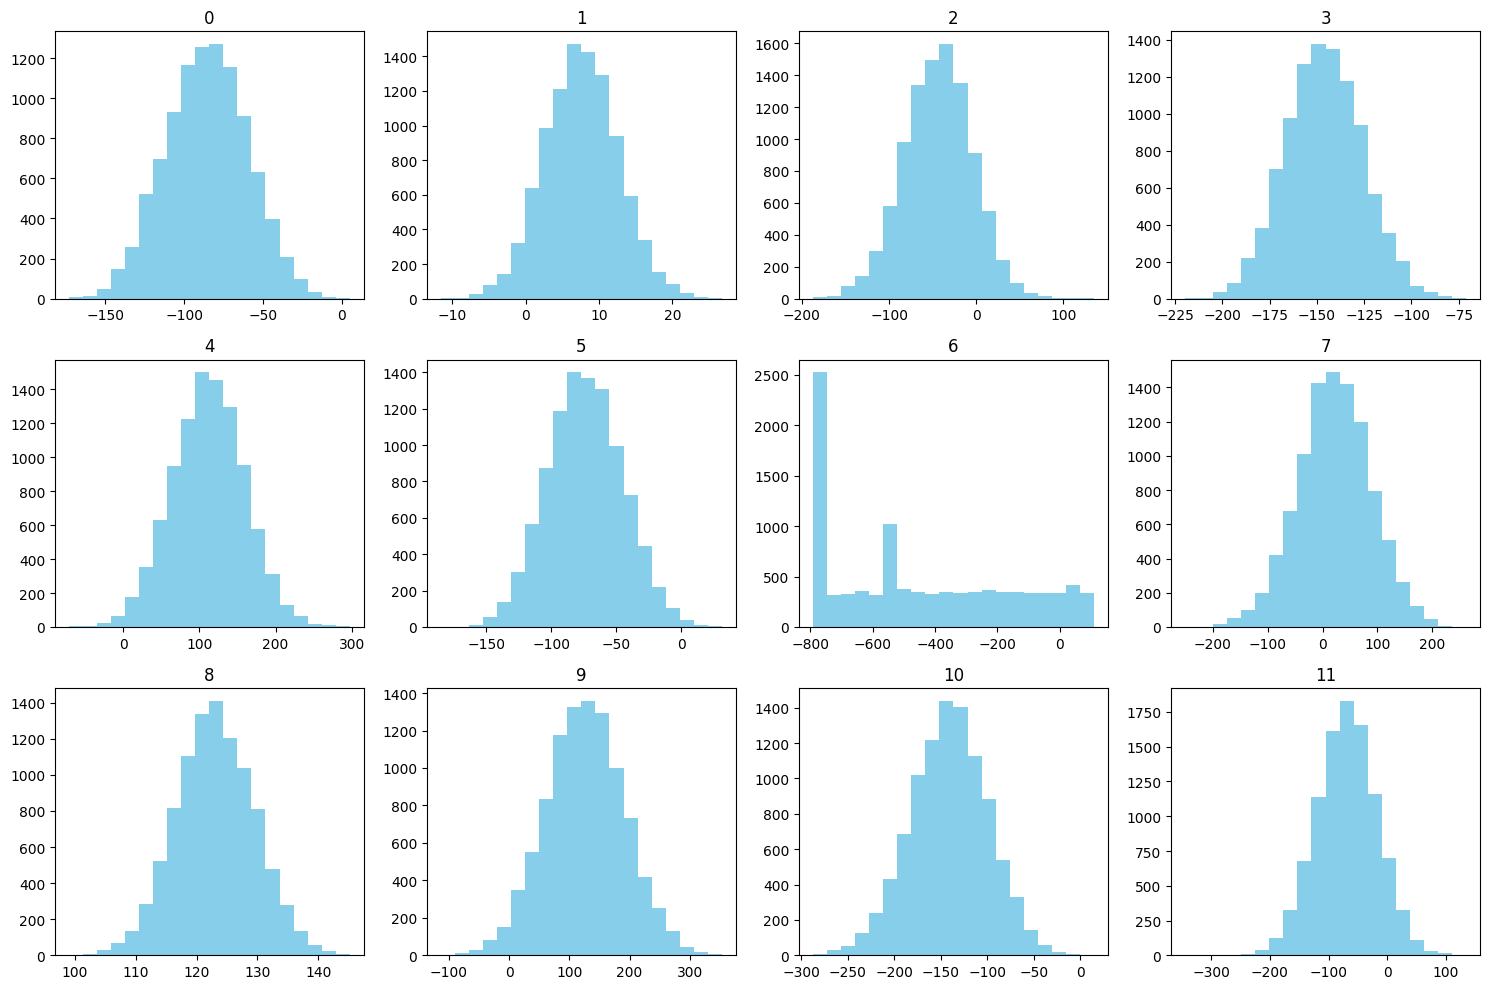

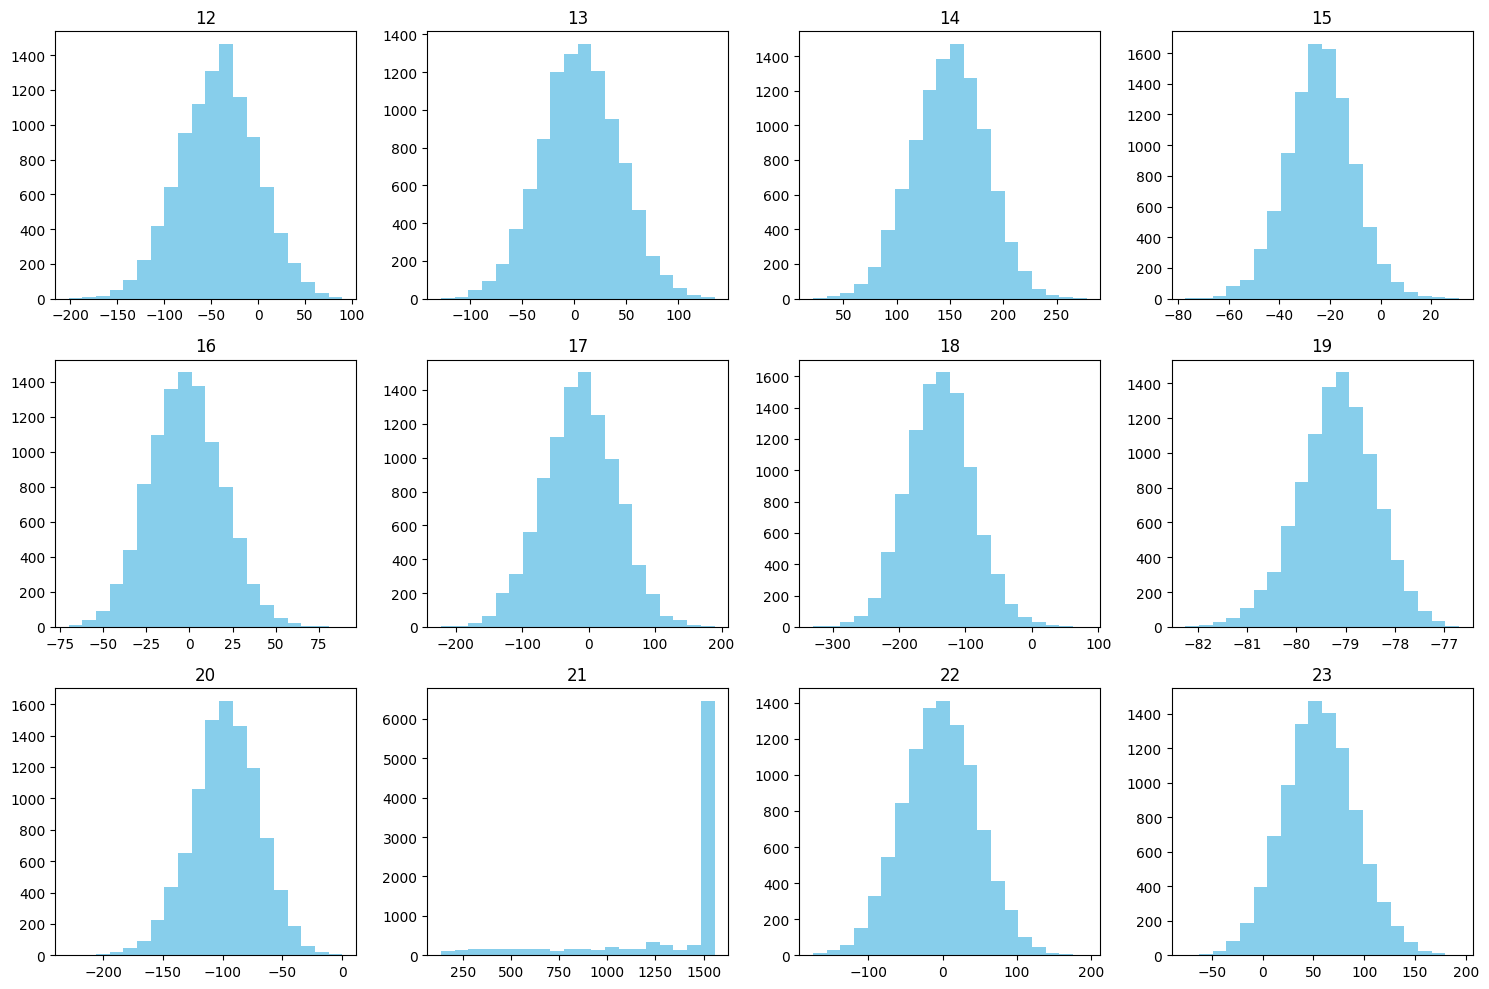

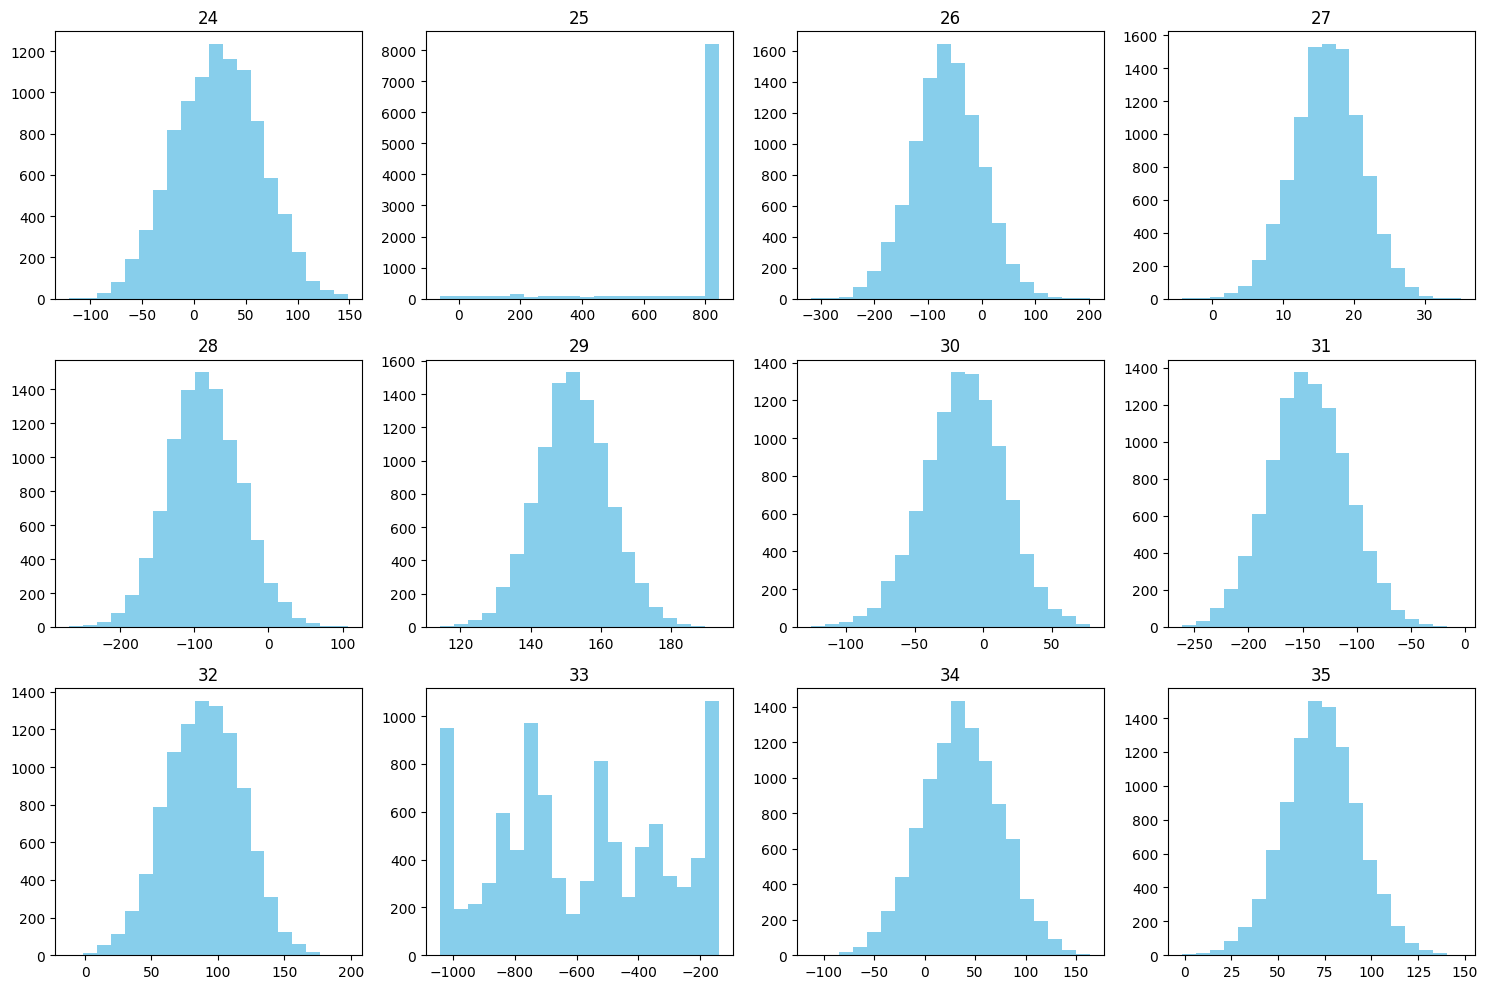

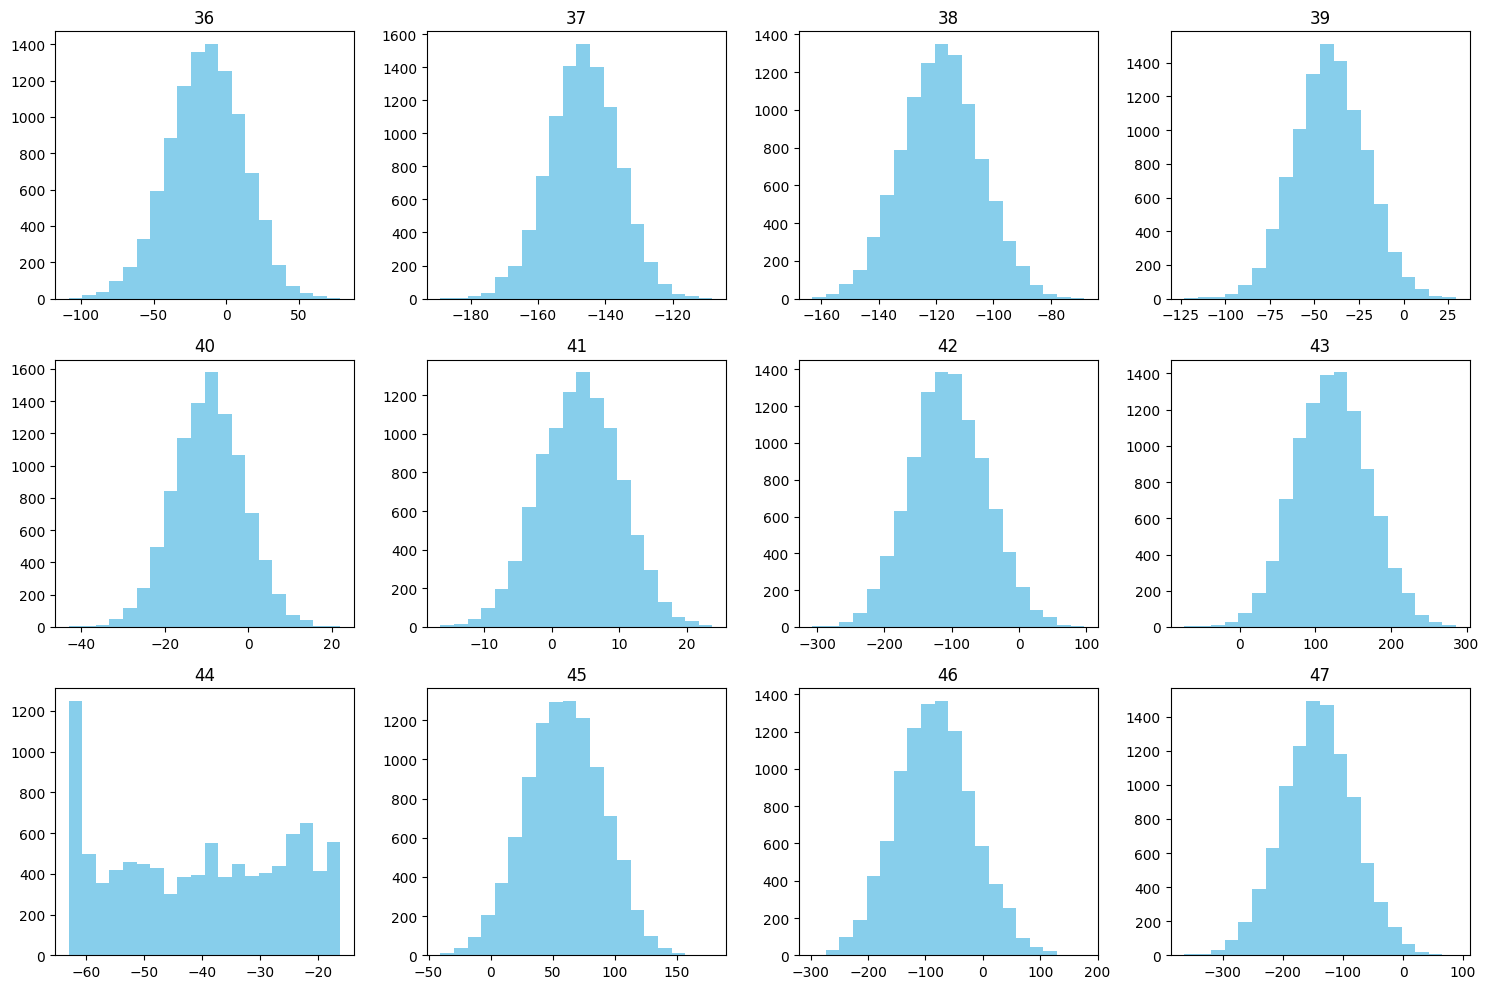

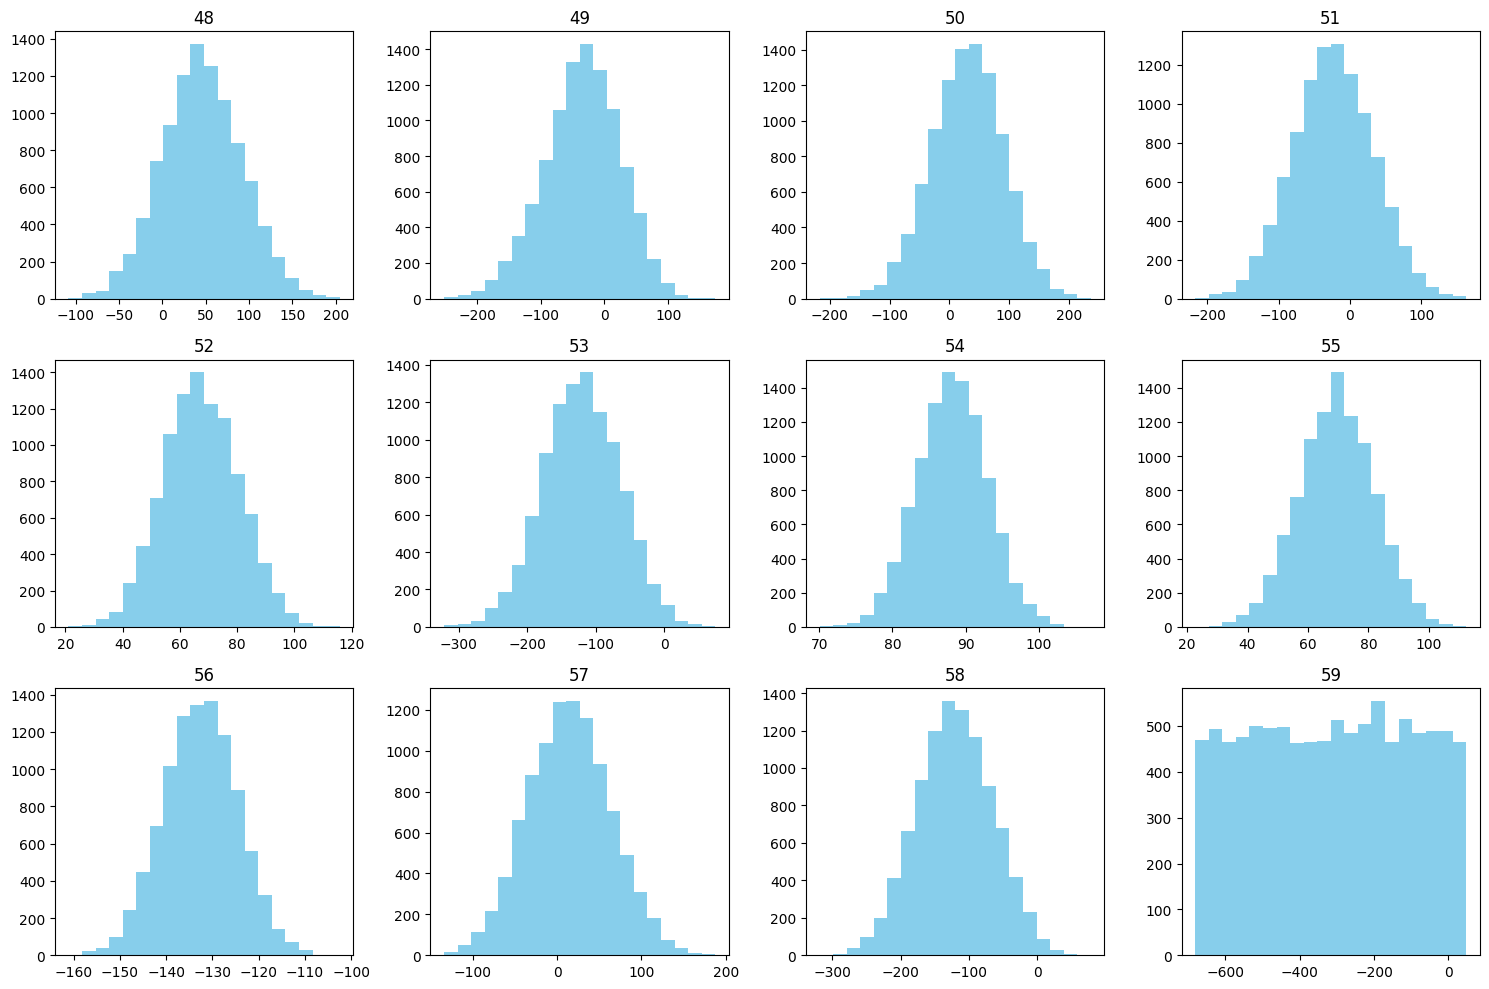

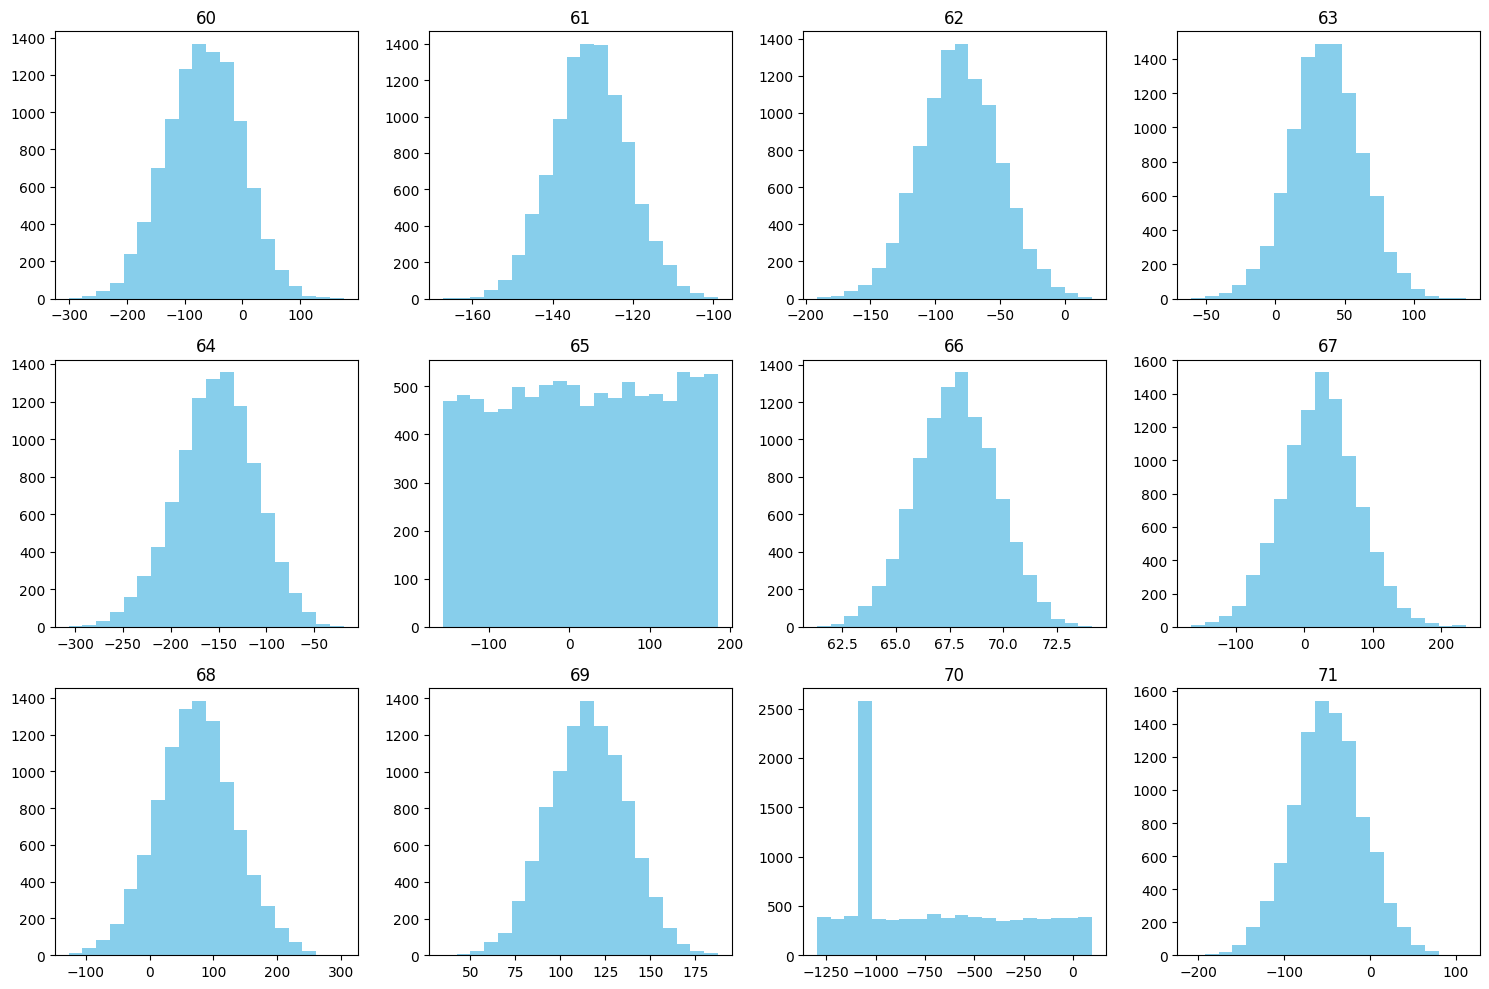

In [21]:
hists(train_queries)

**Итого**: большинство признаков выглядят нормально распределёнными. Проверим это на этапе корреляционного анализа.

Рассмотрим ящики с усами всех признаков.

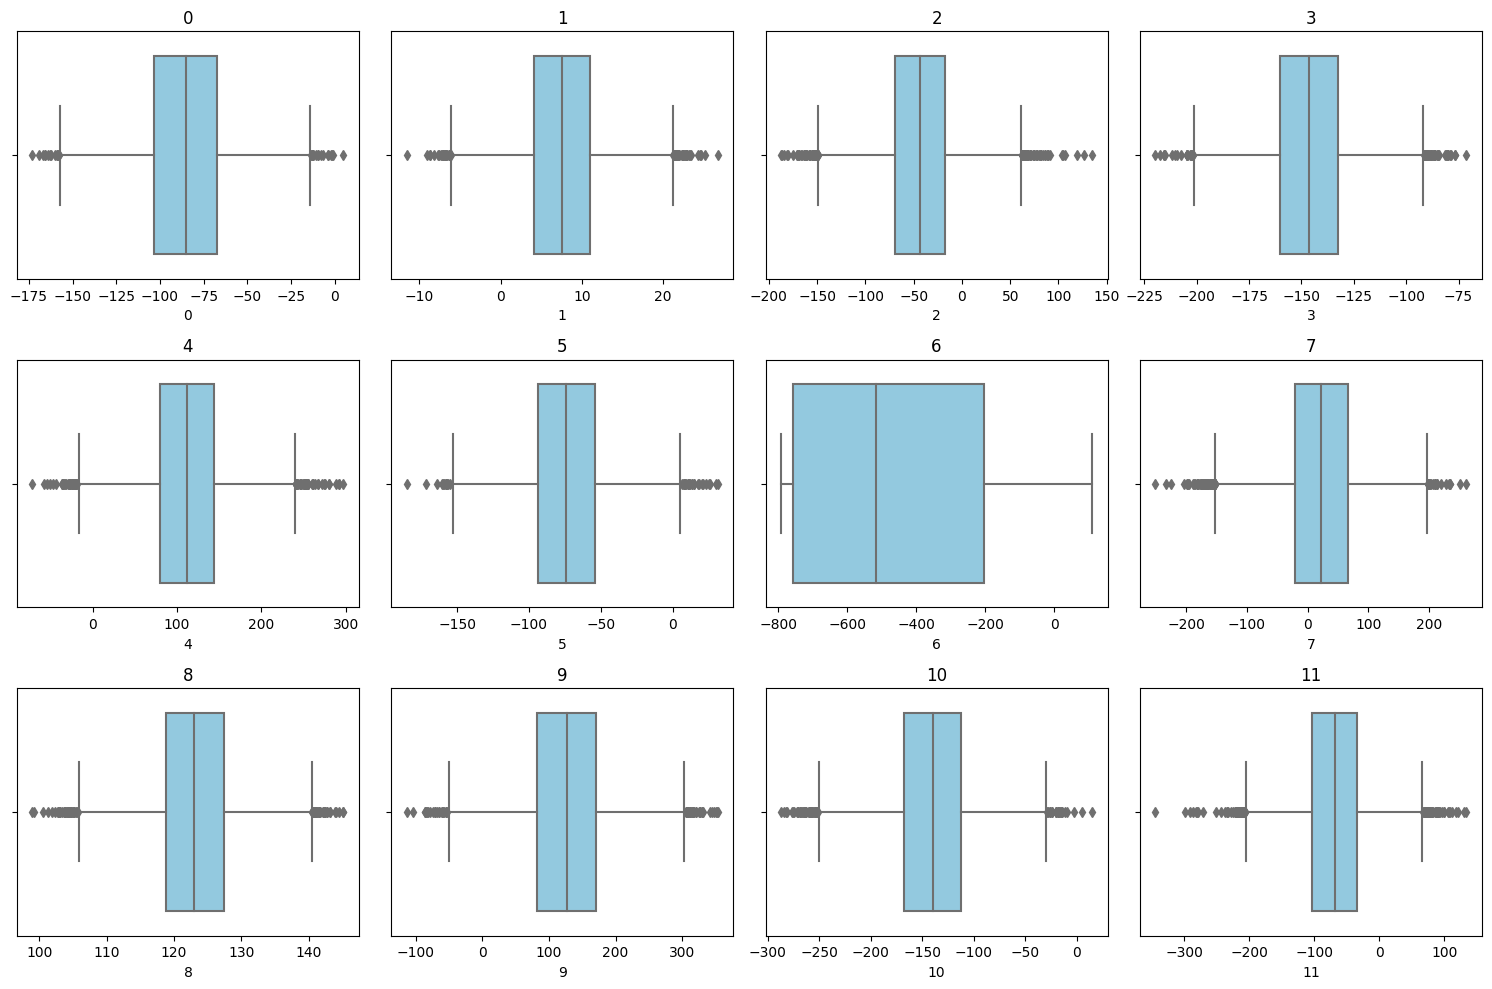

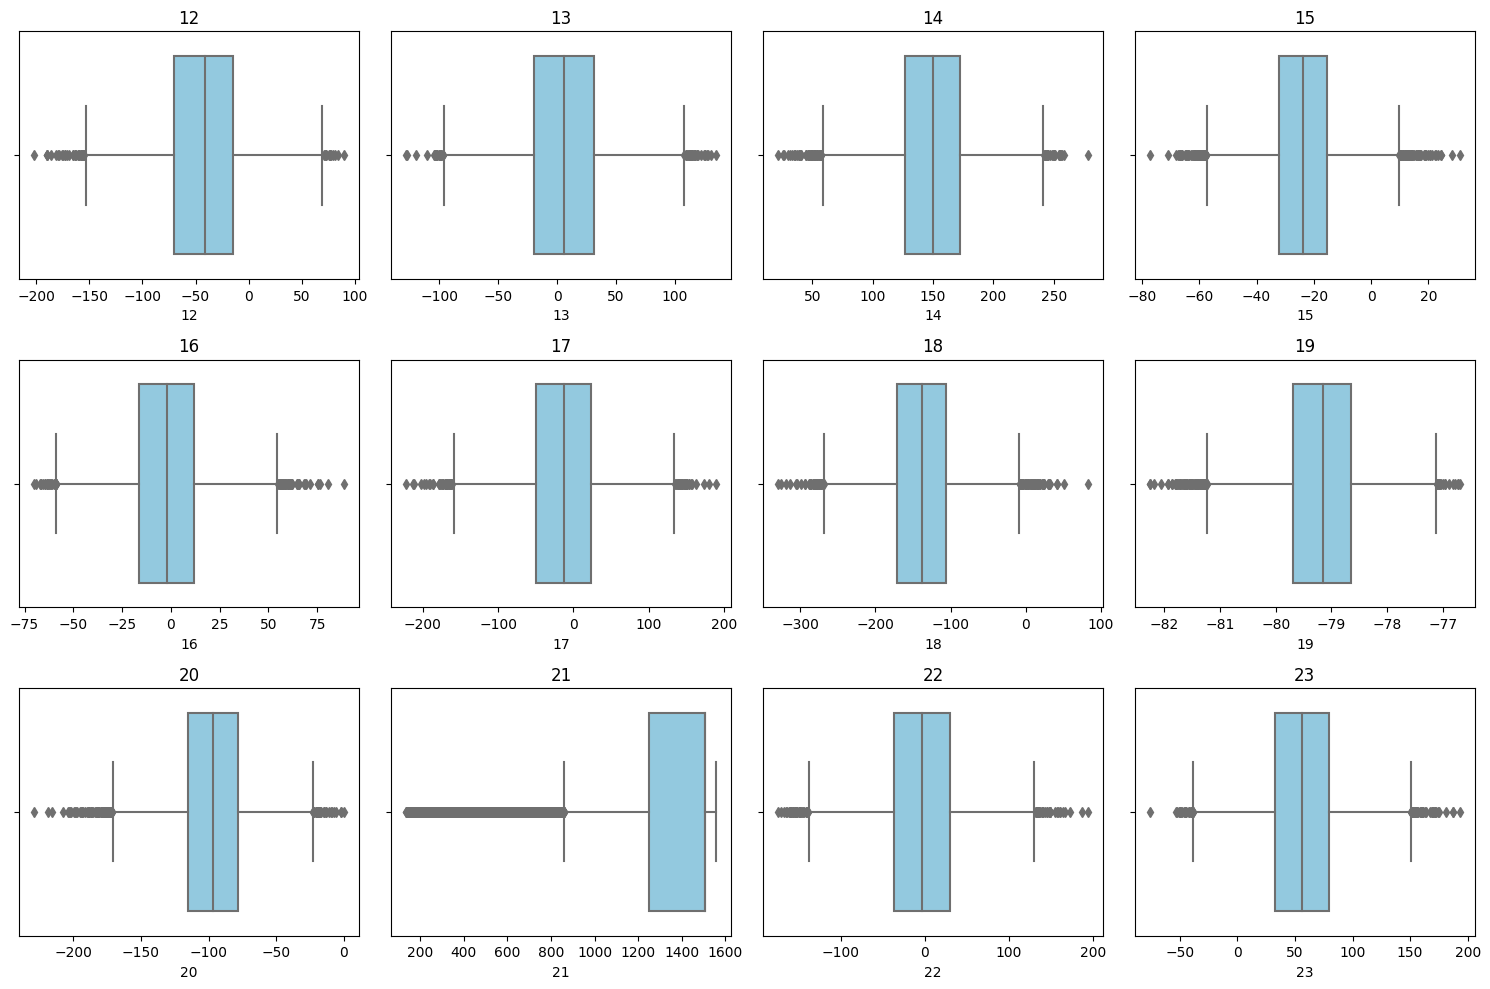

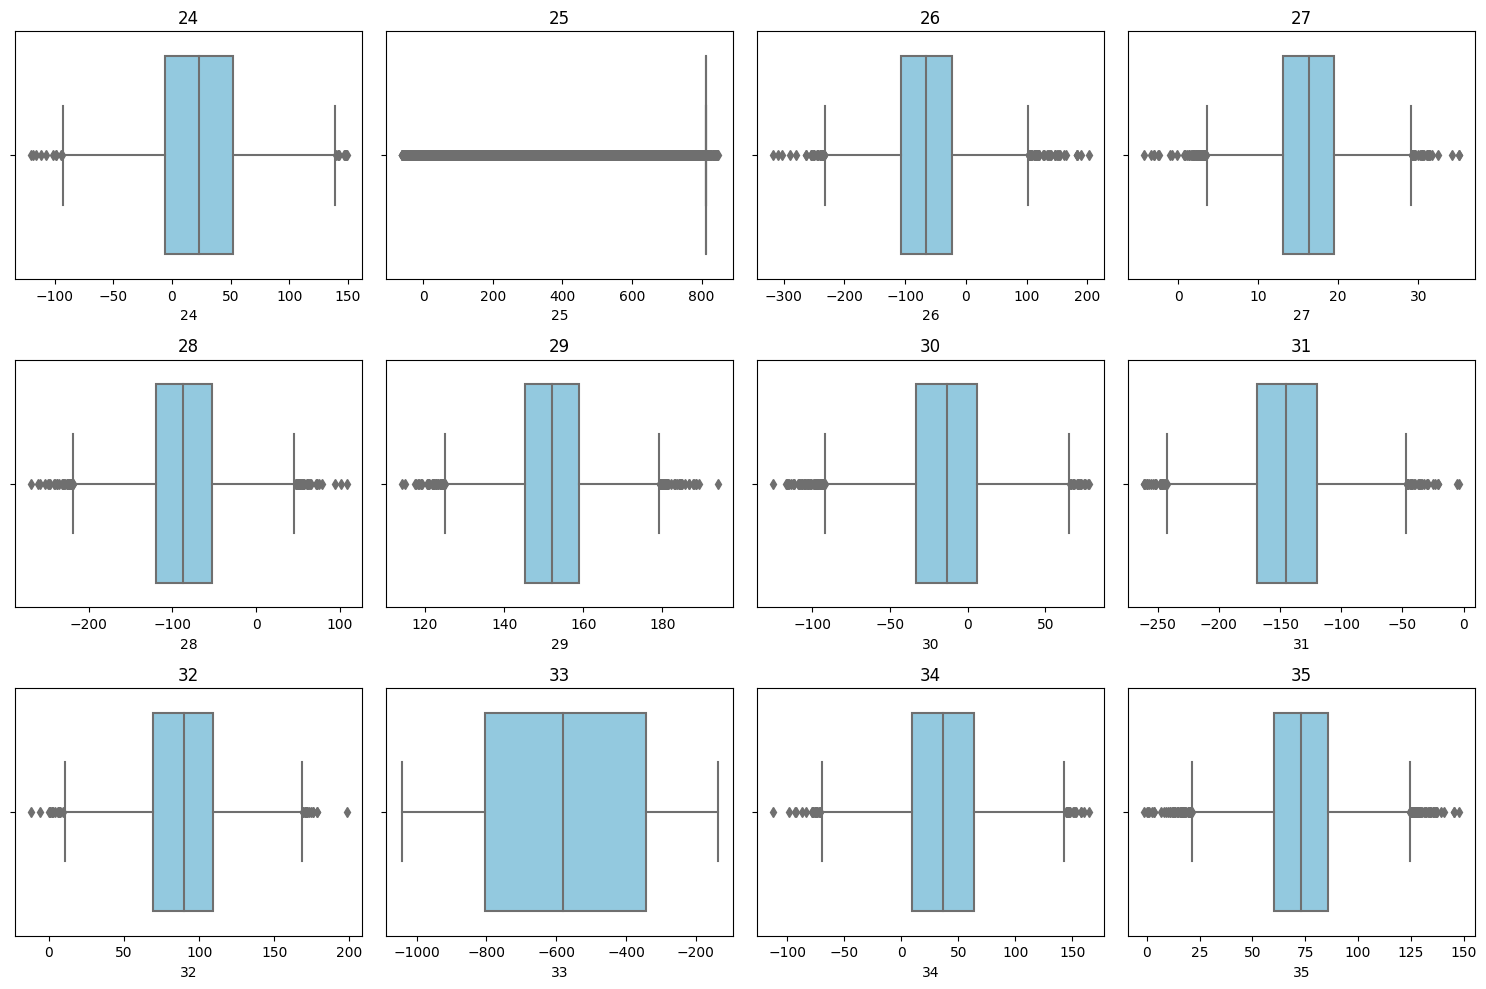

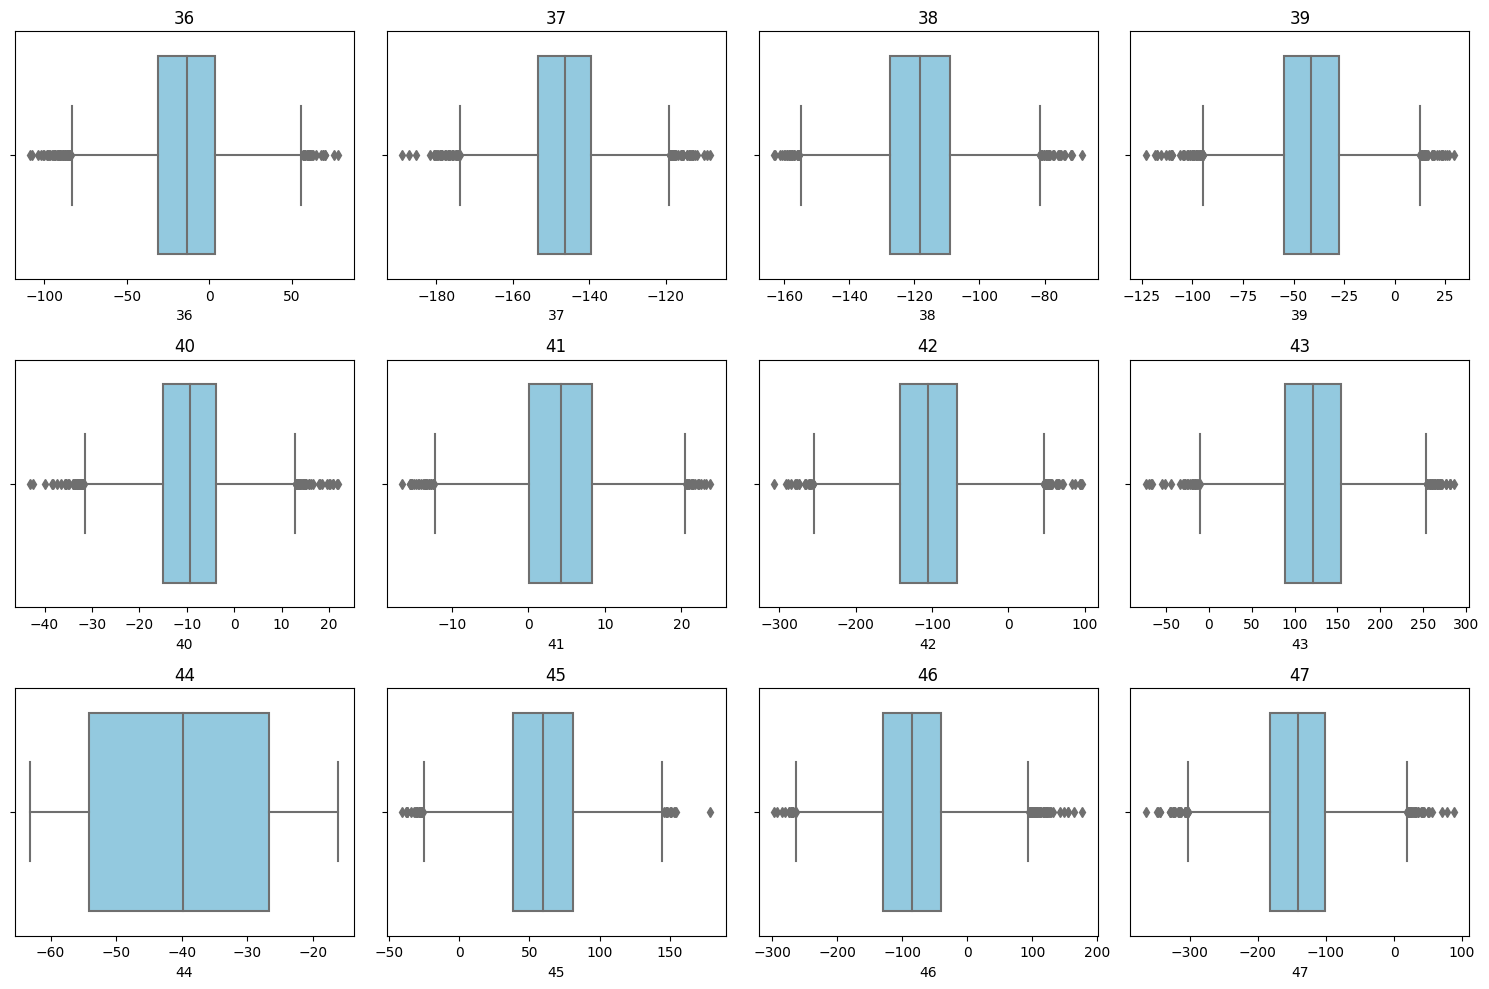

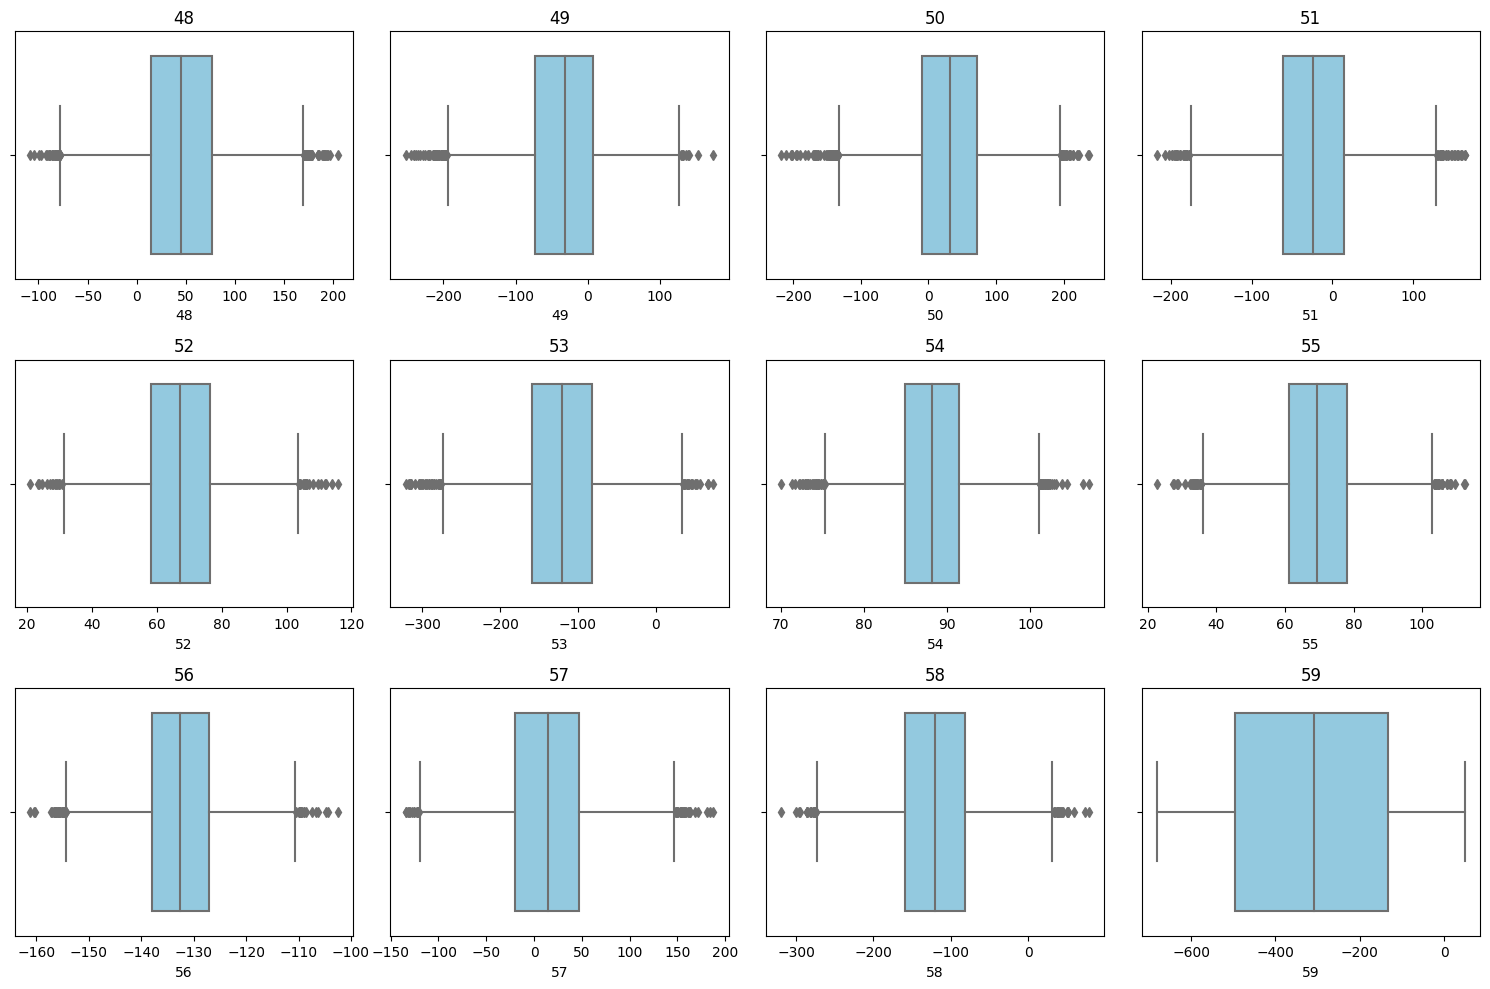

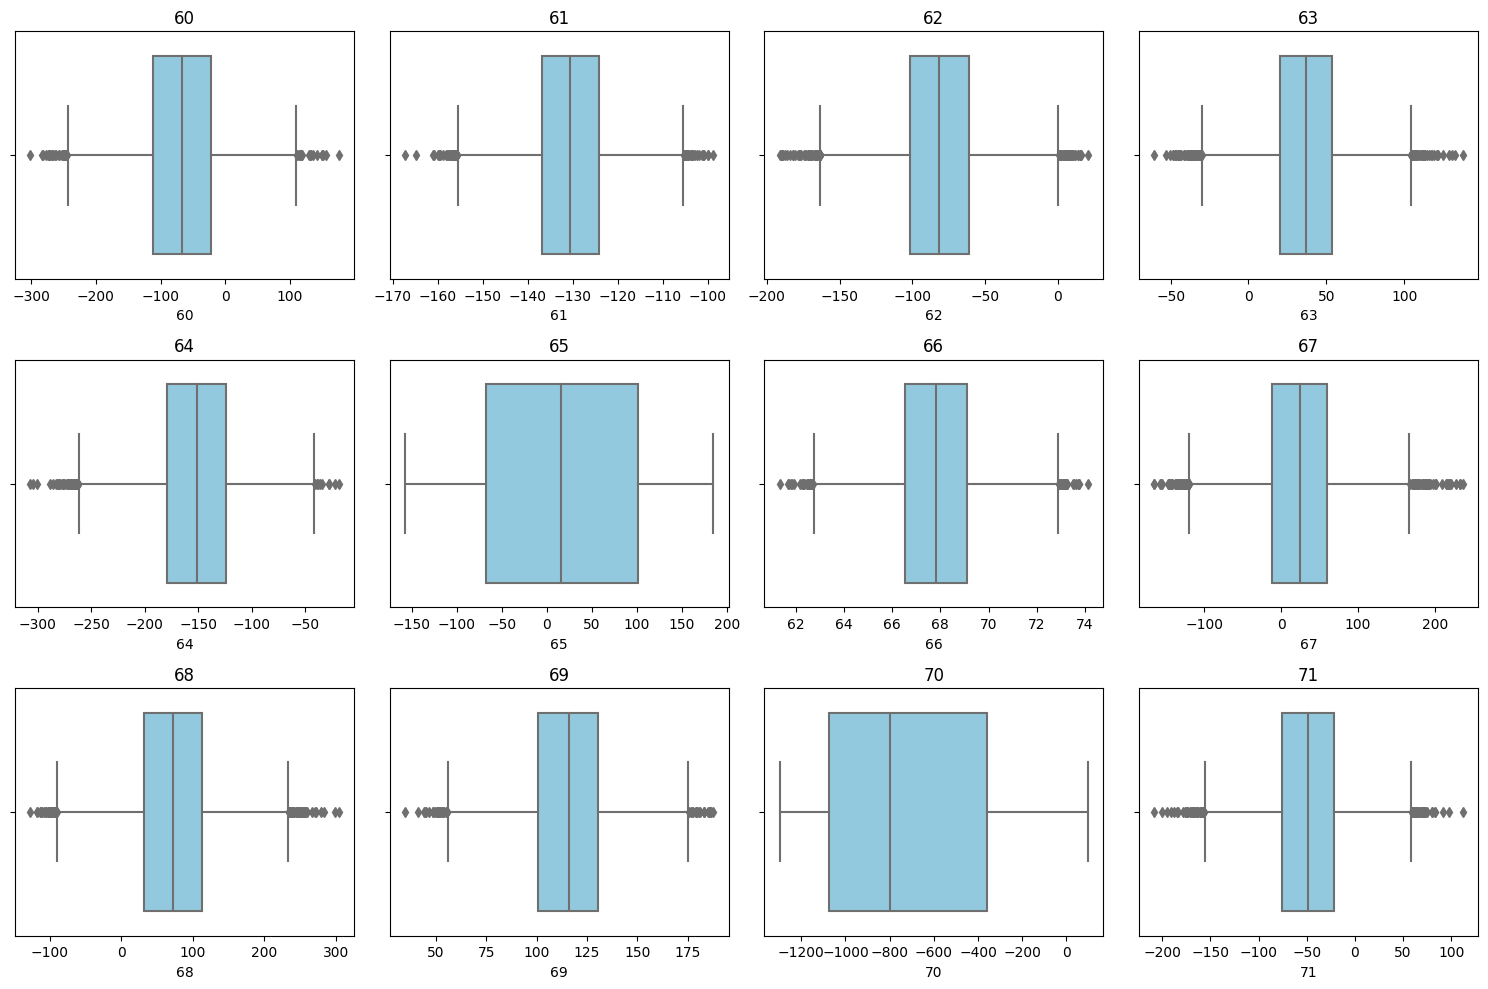

In [22]:
boxplots(train_queries)

**Итого:** самыми "замшумлёнными" координатами эмбеддинга оказались 21 и 25, у остальных значений всё более адекватно.

### Исследуем документы base

In [23]:
docs.describe().T

,count,mean,std,min,25%,50%,75%,max
0,280535.0,-86.262582,24.926896,-189.356020,-103.149743,-86.297714,-69.238668,15.574616
1,280535.0,8.076253,4.950601,-12.594500,4.705760,8.039526,11.466233,28.751917
2,280535.0,-44.602718,38.544201,-231.785920,-69.524600,-43.848522,-19.668575,151.377080
3,280535.0,-146.608060,19.851889,-224.880500,-159.888650,-146.719400,-133.315265,-55.167892
4,280535.0,111.259446,46.359416,-95.240830,80.356810,111.776024,142.368670,299.307920
5,280535.0,-71.881191,28.189068,-188.473330,-91.243848,-71.756645,-52.312802,49.880882
6,280535.0,-393.454026,272.101514,-791.468770,-631.740510,-424.457604,-157.402926,109.631986
7,280535.0,20.399939,64.273309,-296.171050,-22.075390,20.866192,63.991116,301.094240
8,280535.0,123.673489,6.354015,93.684616,119.468280,123.877330,127.967140,147.870910
9,280535.0,124.408196,64.375754,-143.499600,81.645300,123.432480,166.981605,402.994600


**Итого:** среднее значение также находится в пределе от -150 до 150, за редким исключением. Так же, в большинстве случаев, медиана близка к среднему.

Изучим гистограммы всех фичей base.

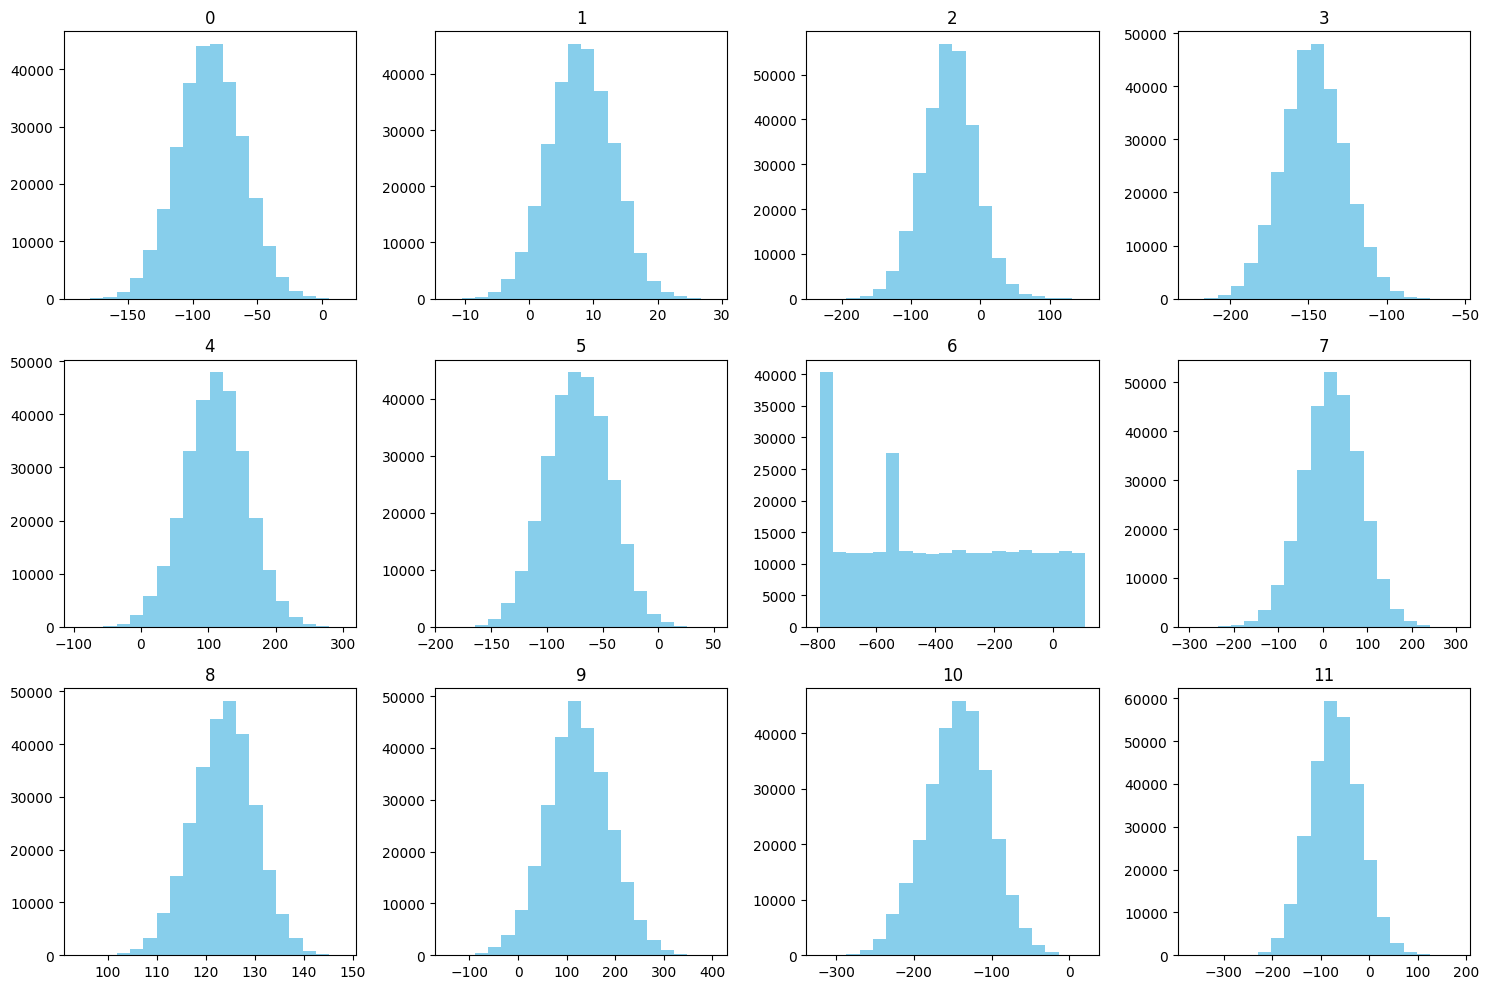

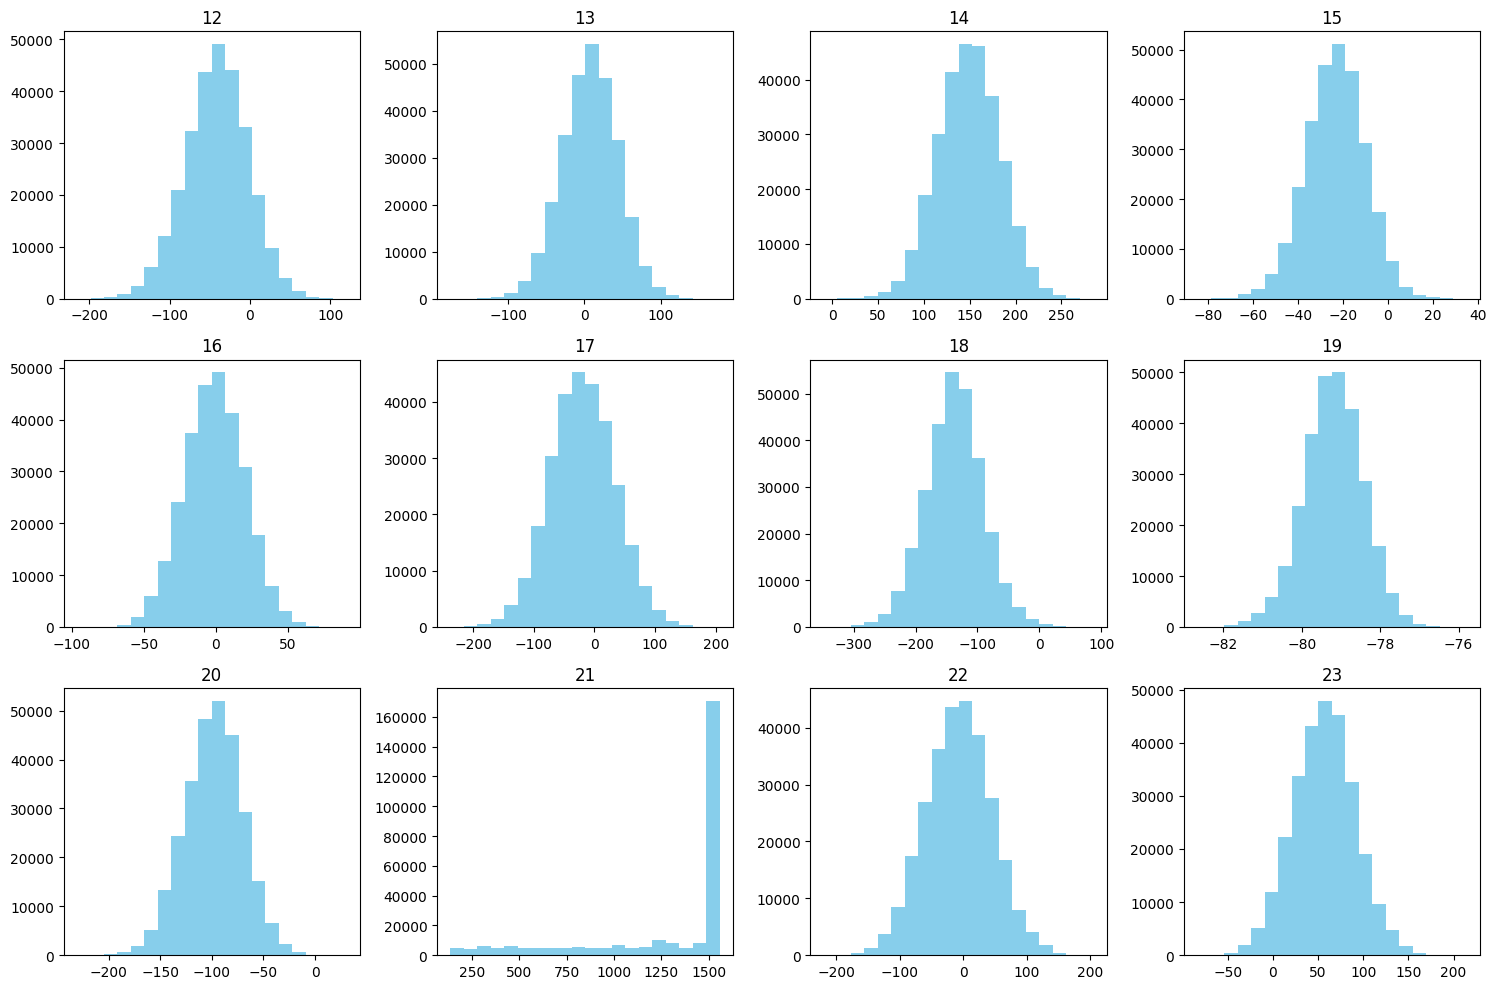

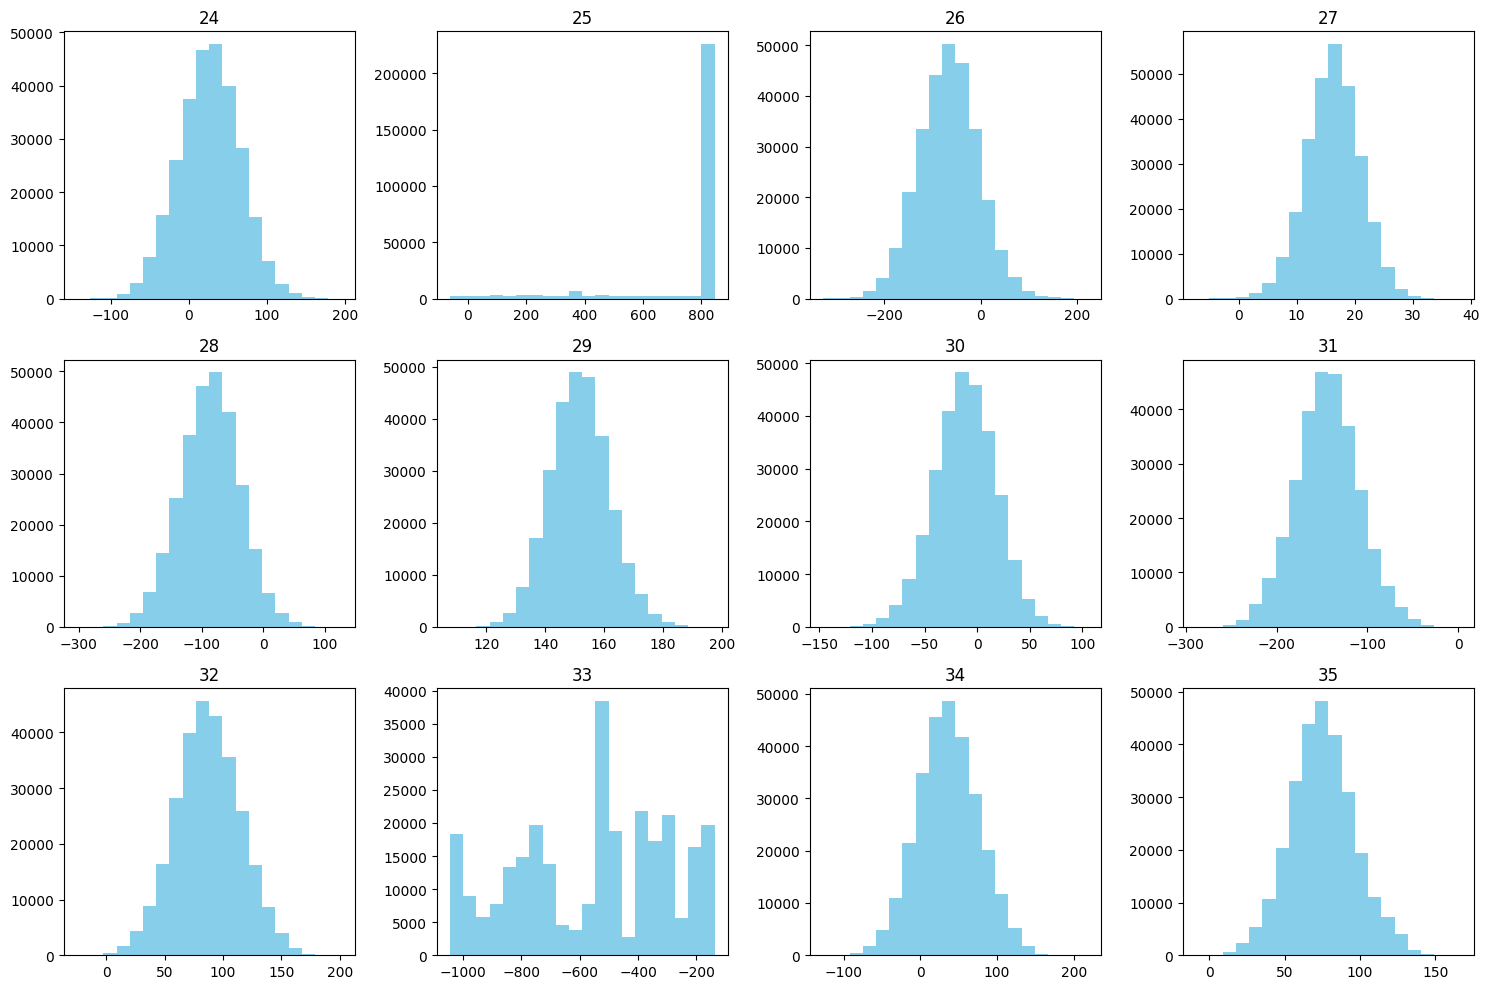

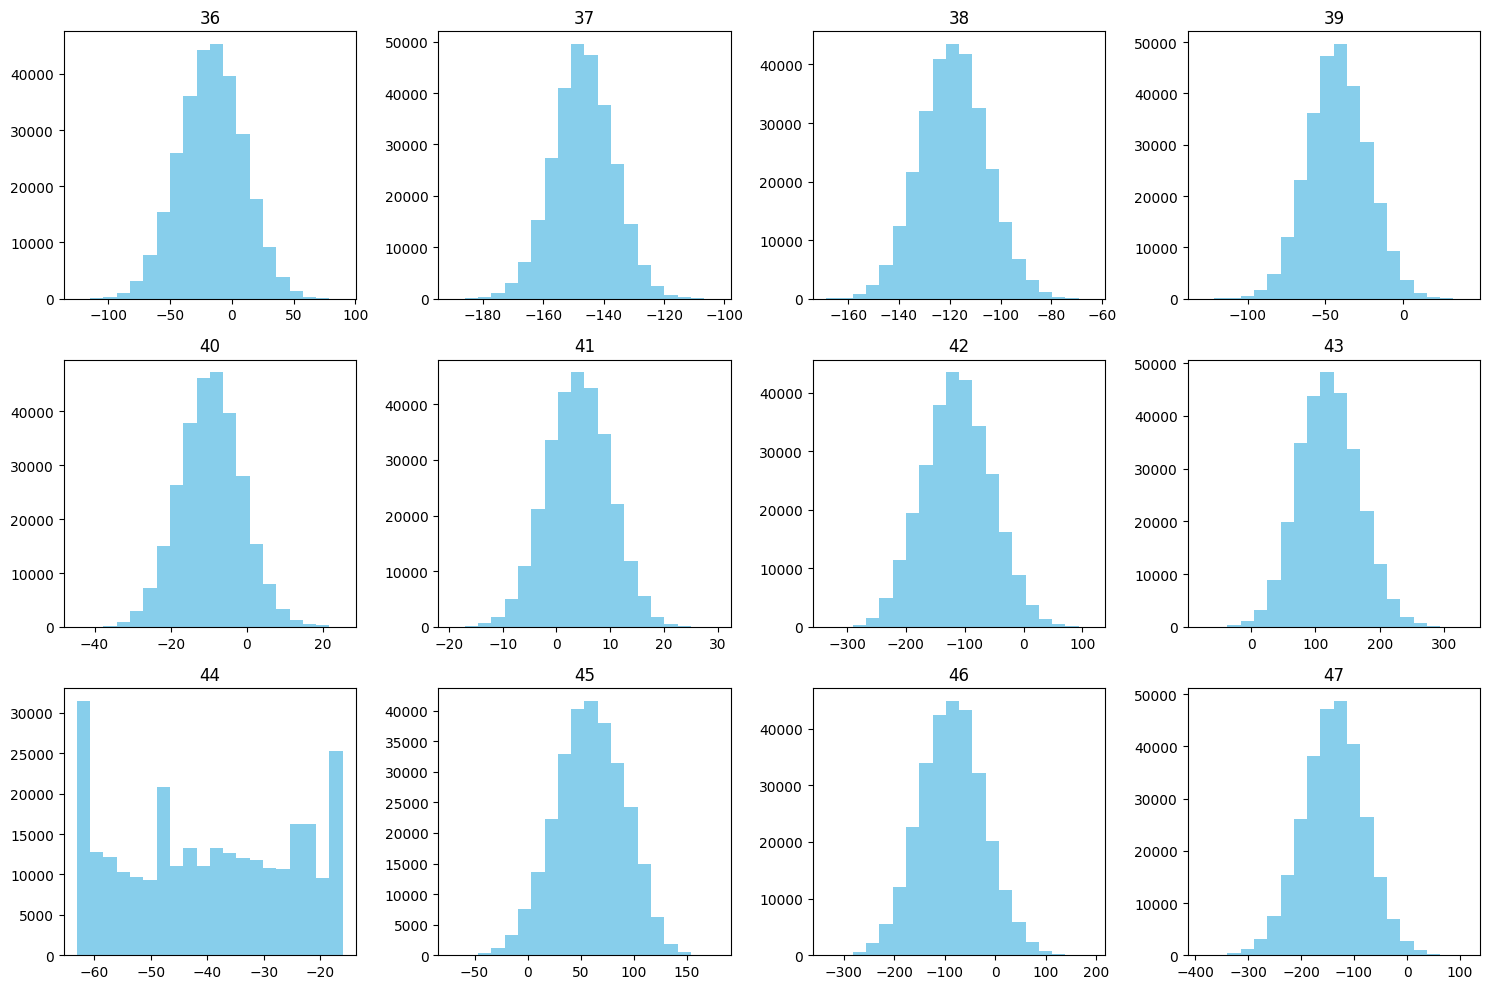

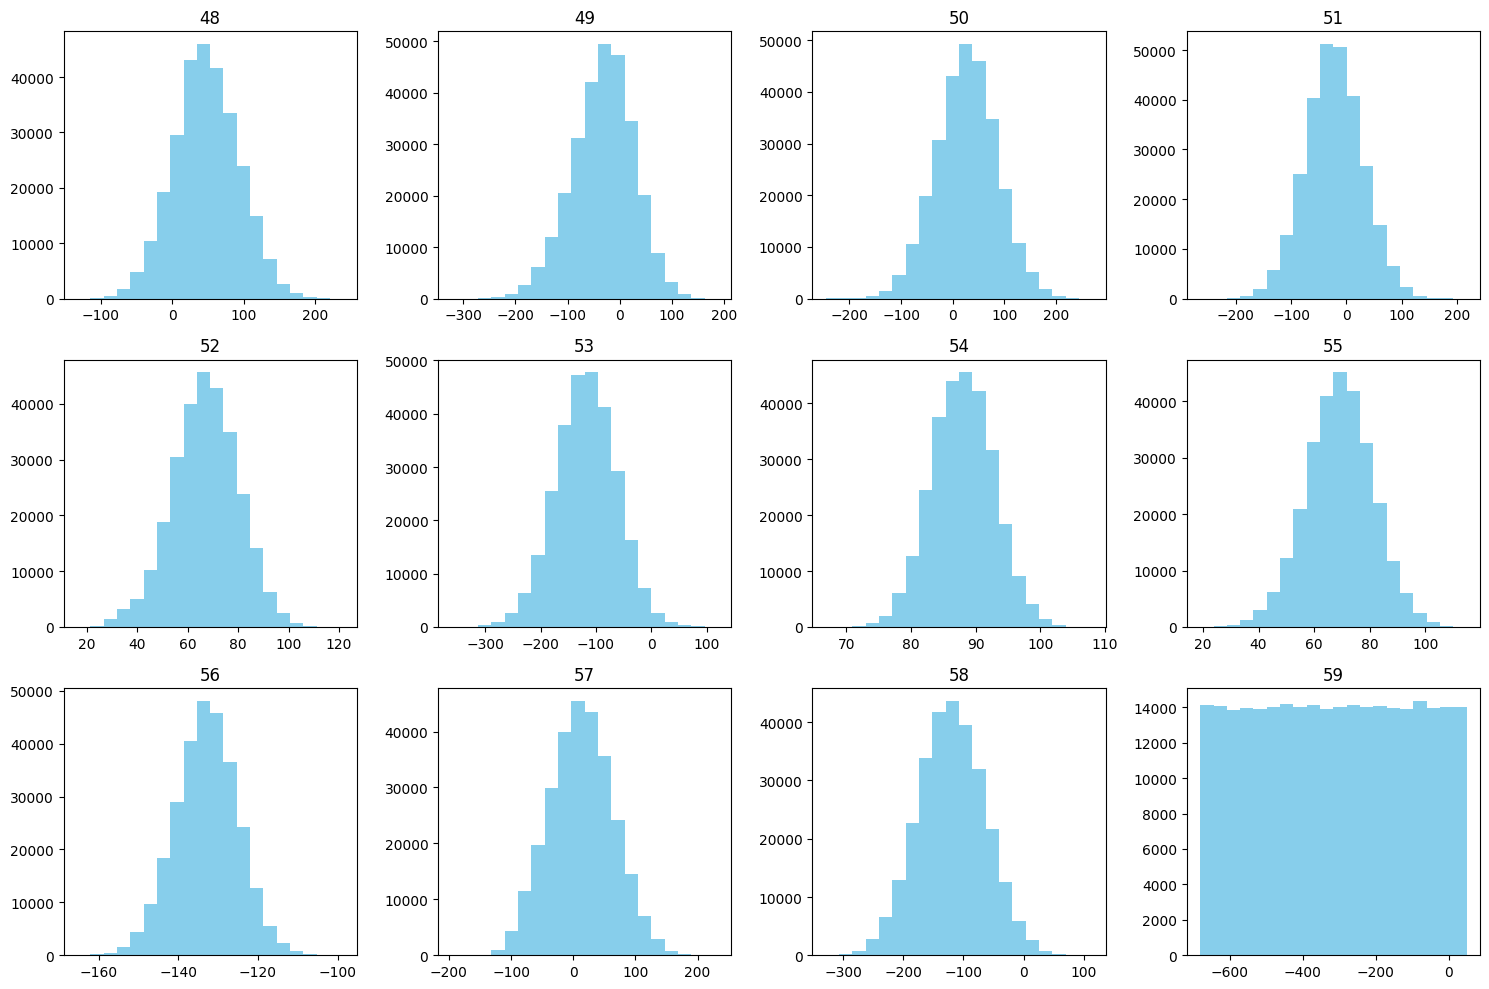

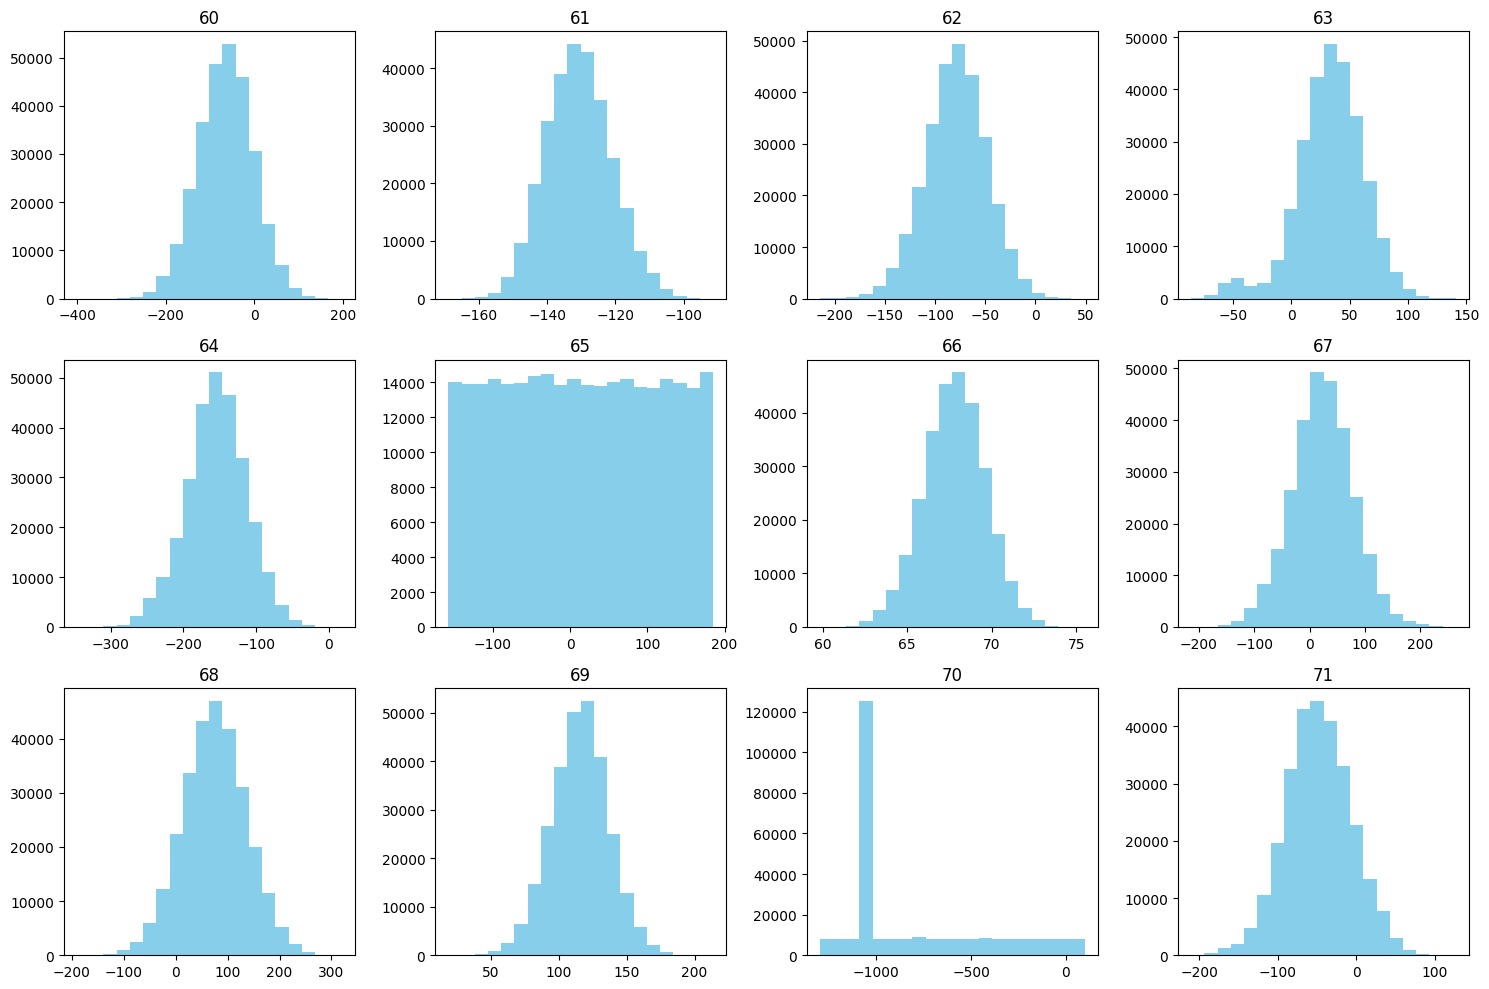

In [24]:
hists(docs)

**Итого:** распределения значений координат эмбеддингов документов очень похожи на распределение тренировочных запросов. Большинство признаков выглядят нормально (проверим позже).

Изучим ящики с усами base.

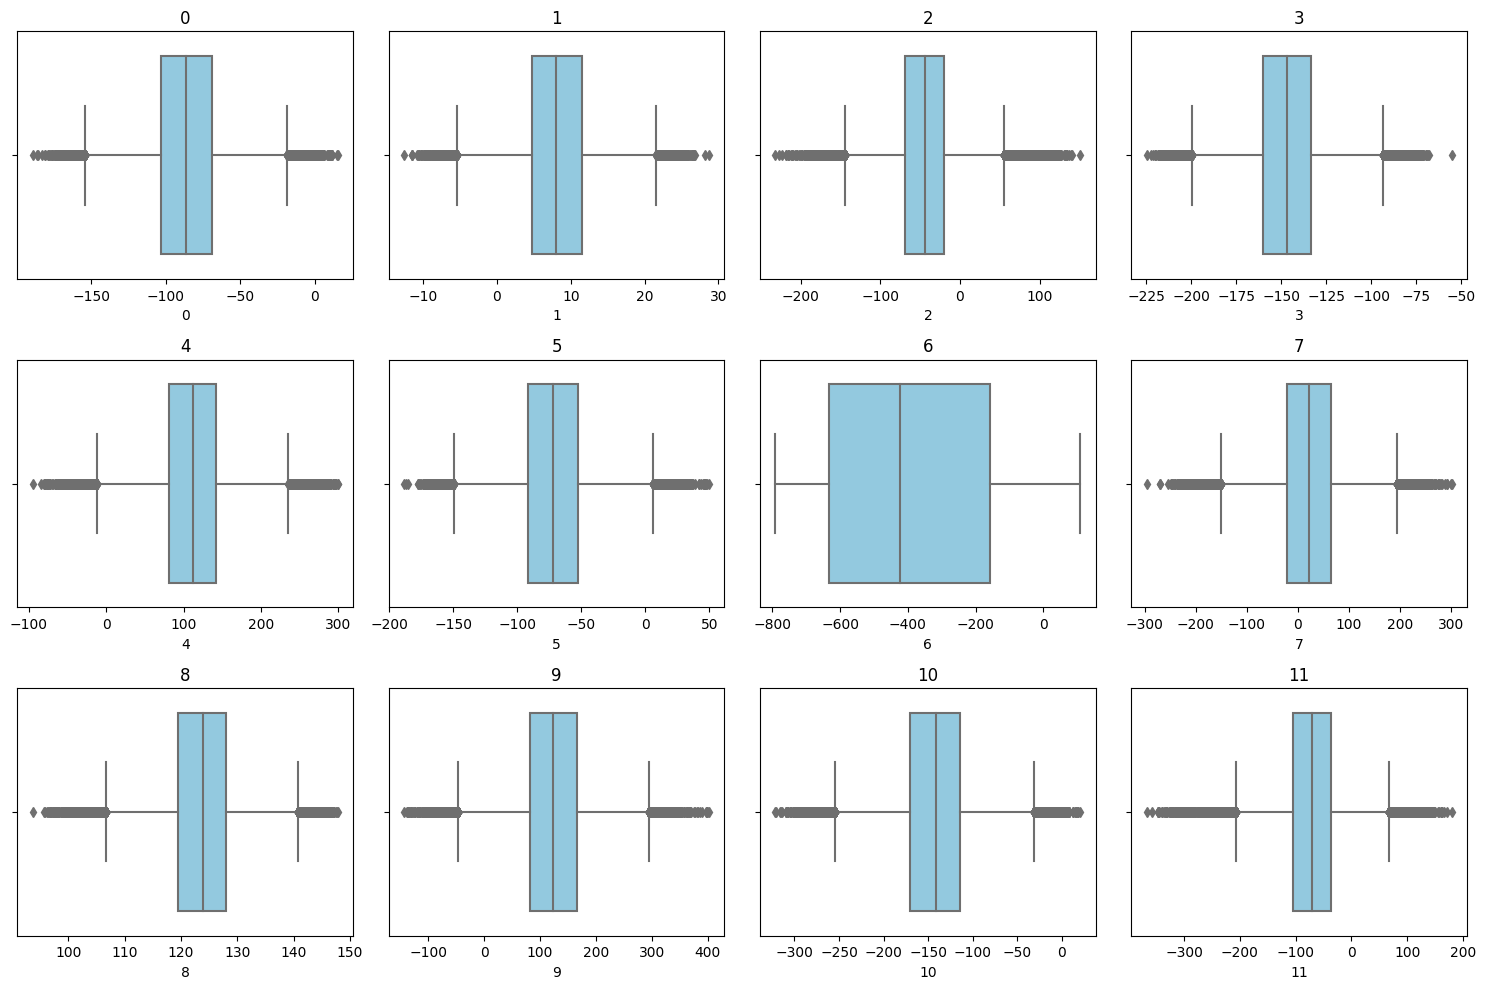

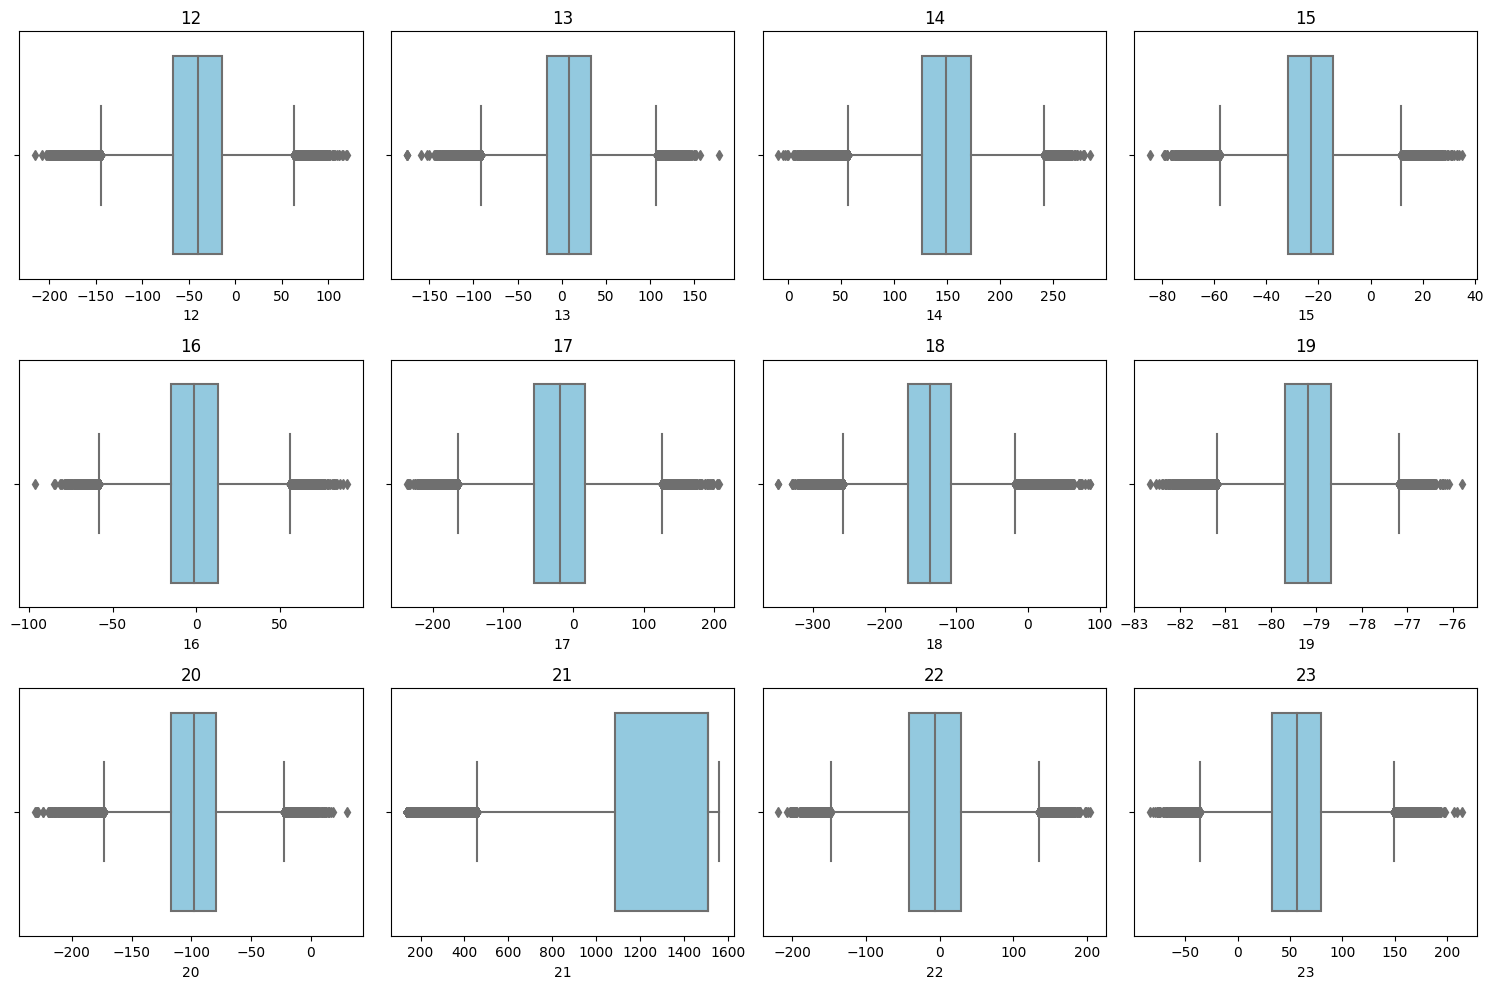

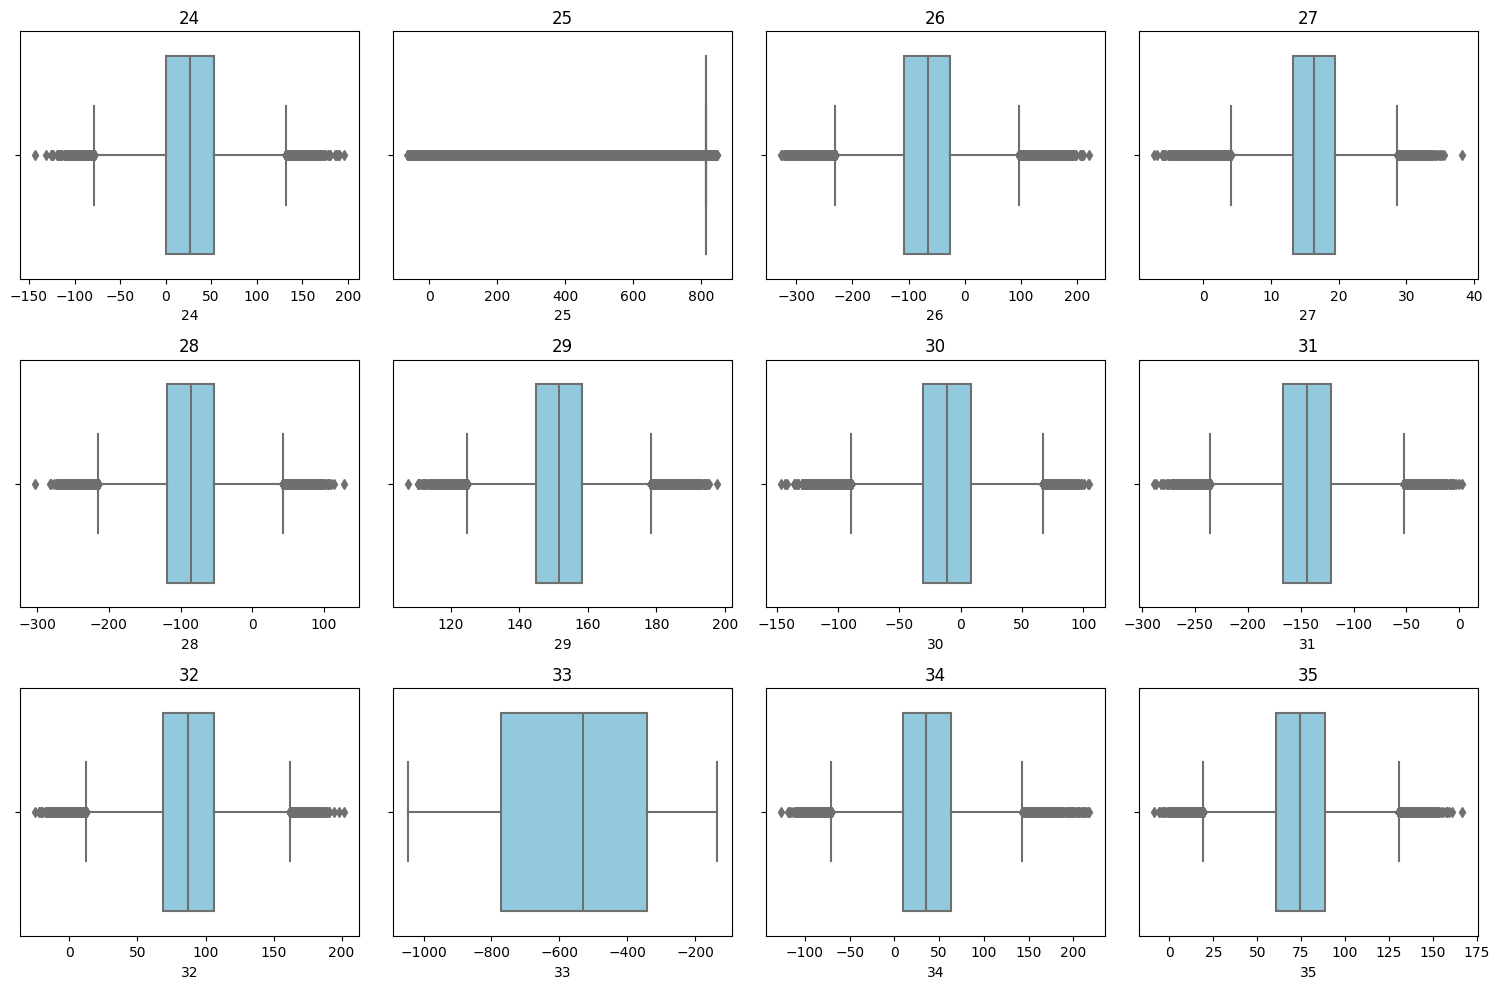

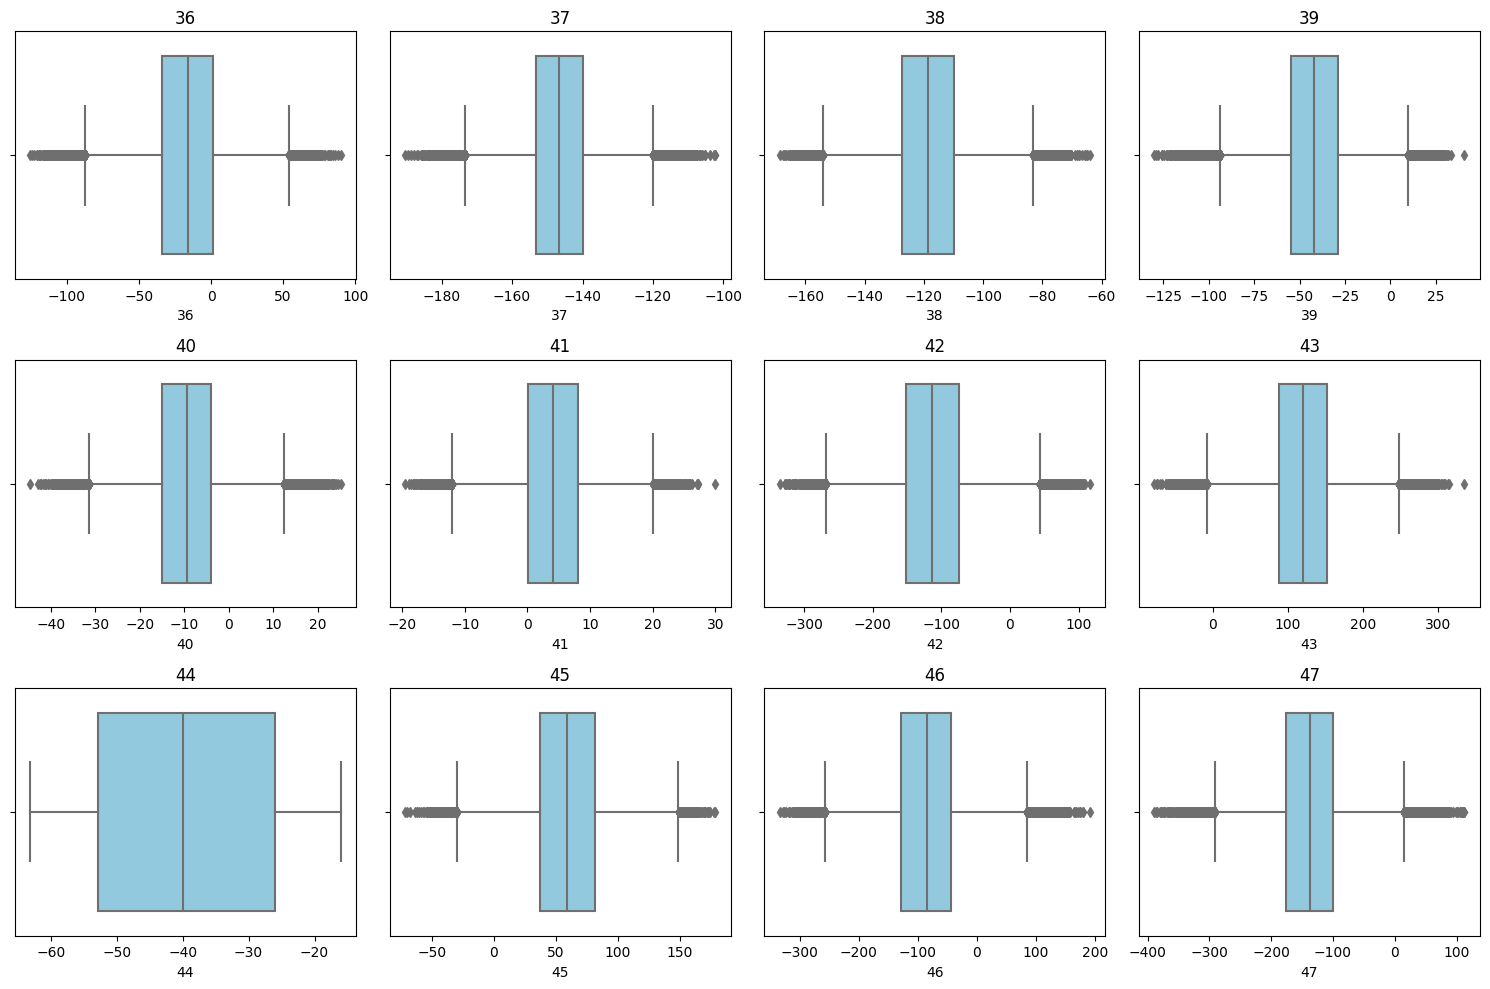

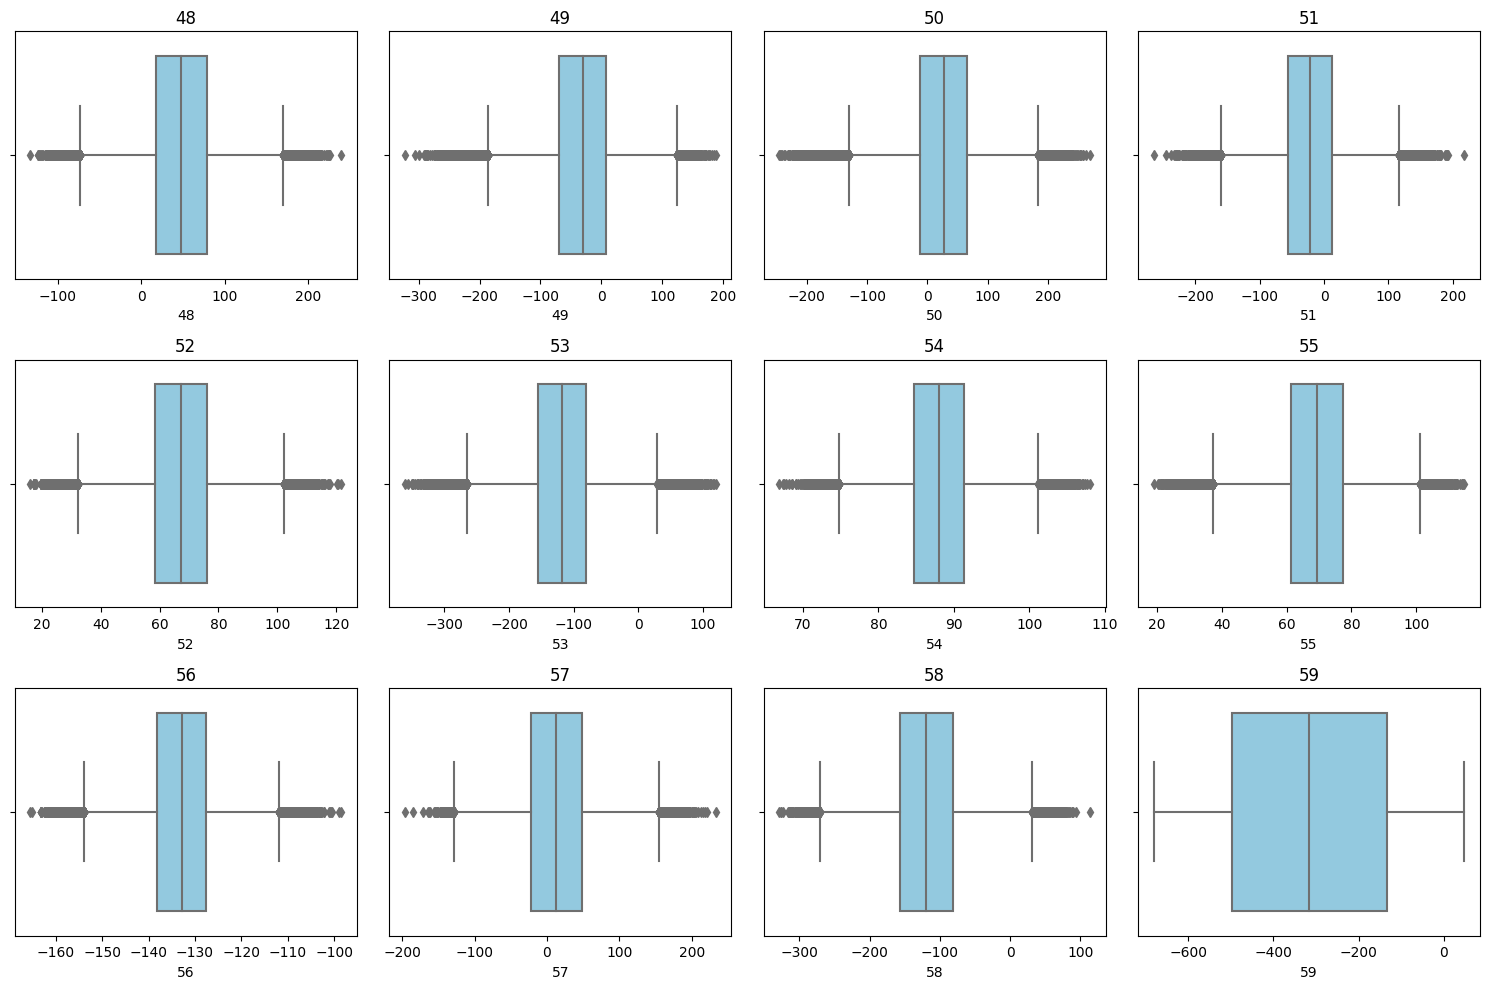

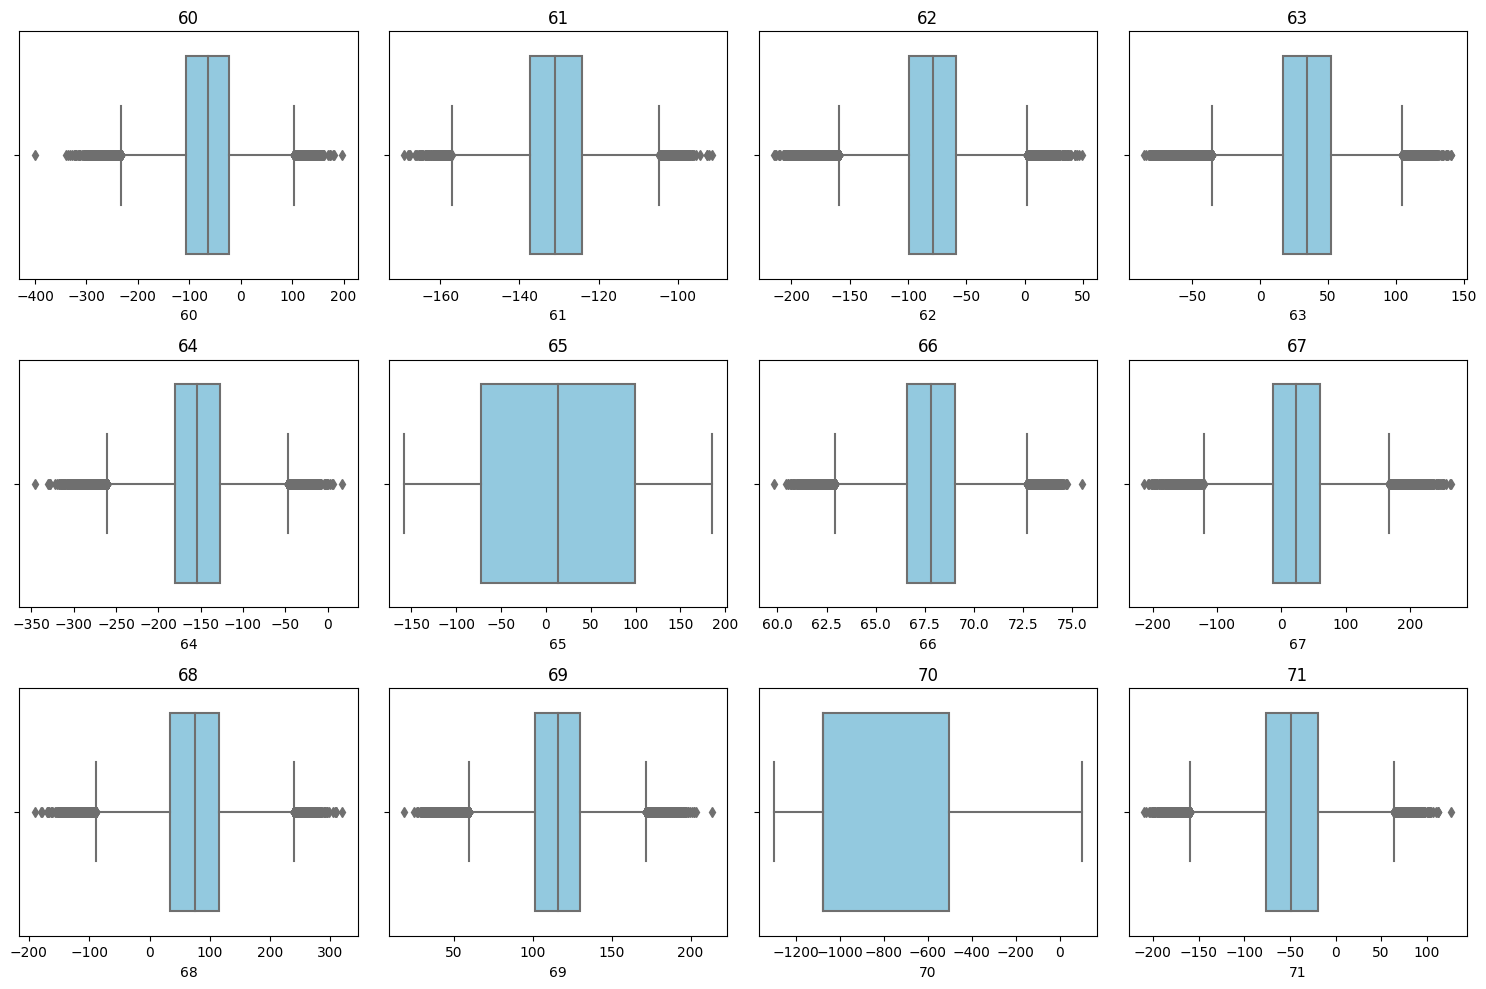

In [25]:
boxplots(docs)

**Итого**: всё как и в тренировочных запросах - несомненно есть выбросы, которые в пределах нормы. Также ведёт себя признак 21 и 25.

**Вывод**: изучены значения эмбеддингов документов и тренировочных запросов.

## Корреляционный анализ

### Иучим распределения фичей эмбеддингов на нормальность.

Начнём с train_queries.

In [26]:
train_queries_interval = []
ebeddings_features = train_queries.select_dtypes(include=['float64', 'int64']).columns

alpha = 0.05

for cord in ebeddings_features:
    statistic, p_value = stats.shapiro(train_queries[cord])
    if p_value <= alpha:
        train_queries_interval.append(cord)

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [27]:
print(f"Количество ненормально распределённых признаков: {len(train_queries_interval)}")

Количество ненормально распределённых признаков: 50


Изучим на нормальность распределения признаки из документов.

In [28]:
docs_interval = []
norm = []
ebeddings_features = docs.select_dtypes(include=['float64', 'int64']).columns

alpha = 0.05

for cord in ebeddings_features:
    statistic, p_value = stats.shapiro(docs[cord])
    if p_value <= alpha:
        docs_interval.append(cord)
    else:
        norm.append(cord)

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [29]:
print(f"Количество ненормально распределённых признаков: {len(train_queries_interval)}")

Количество ненормально распределённых признаков: 50


Убедимся, что это одни и теже значения.

In [30]:
print(train_queries_interval == docs_interval)

False


**Итого**: как видно, не все координаты эмбеддинга документа с нормальным распределением соответствуют нормально распределённым координатам эмбеддингов запросов.

**Итого**: выявлены признаки с ненормальным распределением.

### Построим матрицы корреляций

Поскольку были обнаружены ненормально распределённые признаки, то строить тепловые карты будем с помощью коэффициента корреляции Спирмена.

Построим матрицу корреляций для тренировочных запросов.

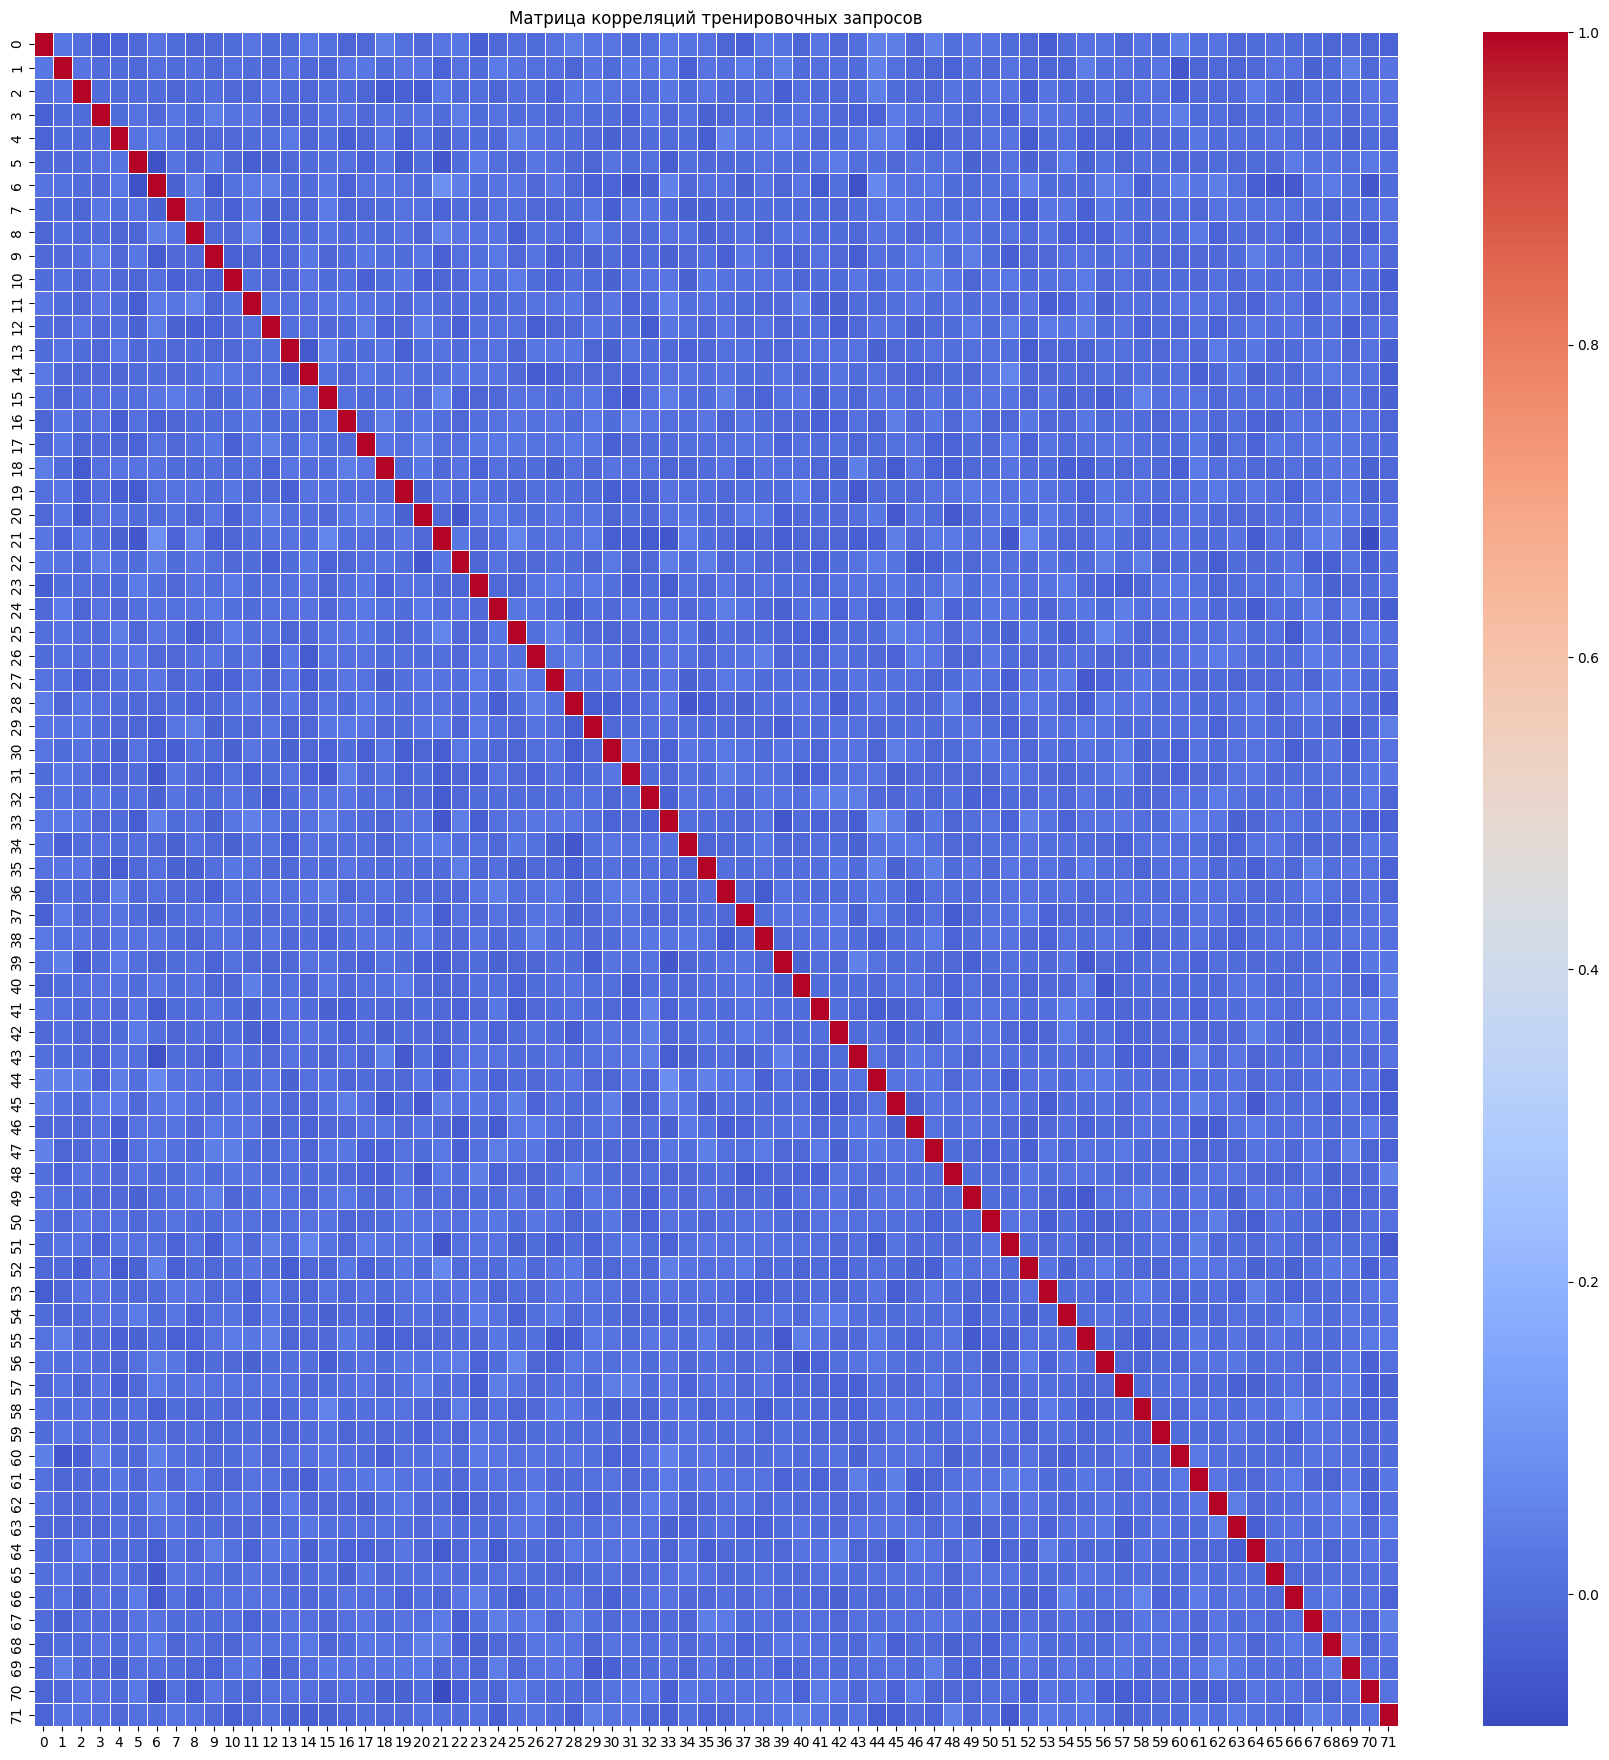

In [31]:
plt.figure(figsize=(22, 22))
sns.heatmap(train_queries.drop(['Id', 'Target'], axis=1)\
            .corr(method='spearman'), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций тренировочных запросов')
plt.show()

**Итого**: мультиколлинеарность не обнаружена.

Построим матрицу корреляций для документов.

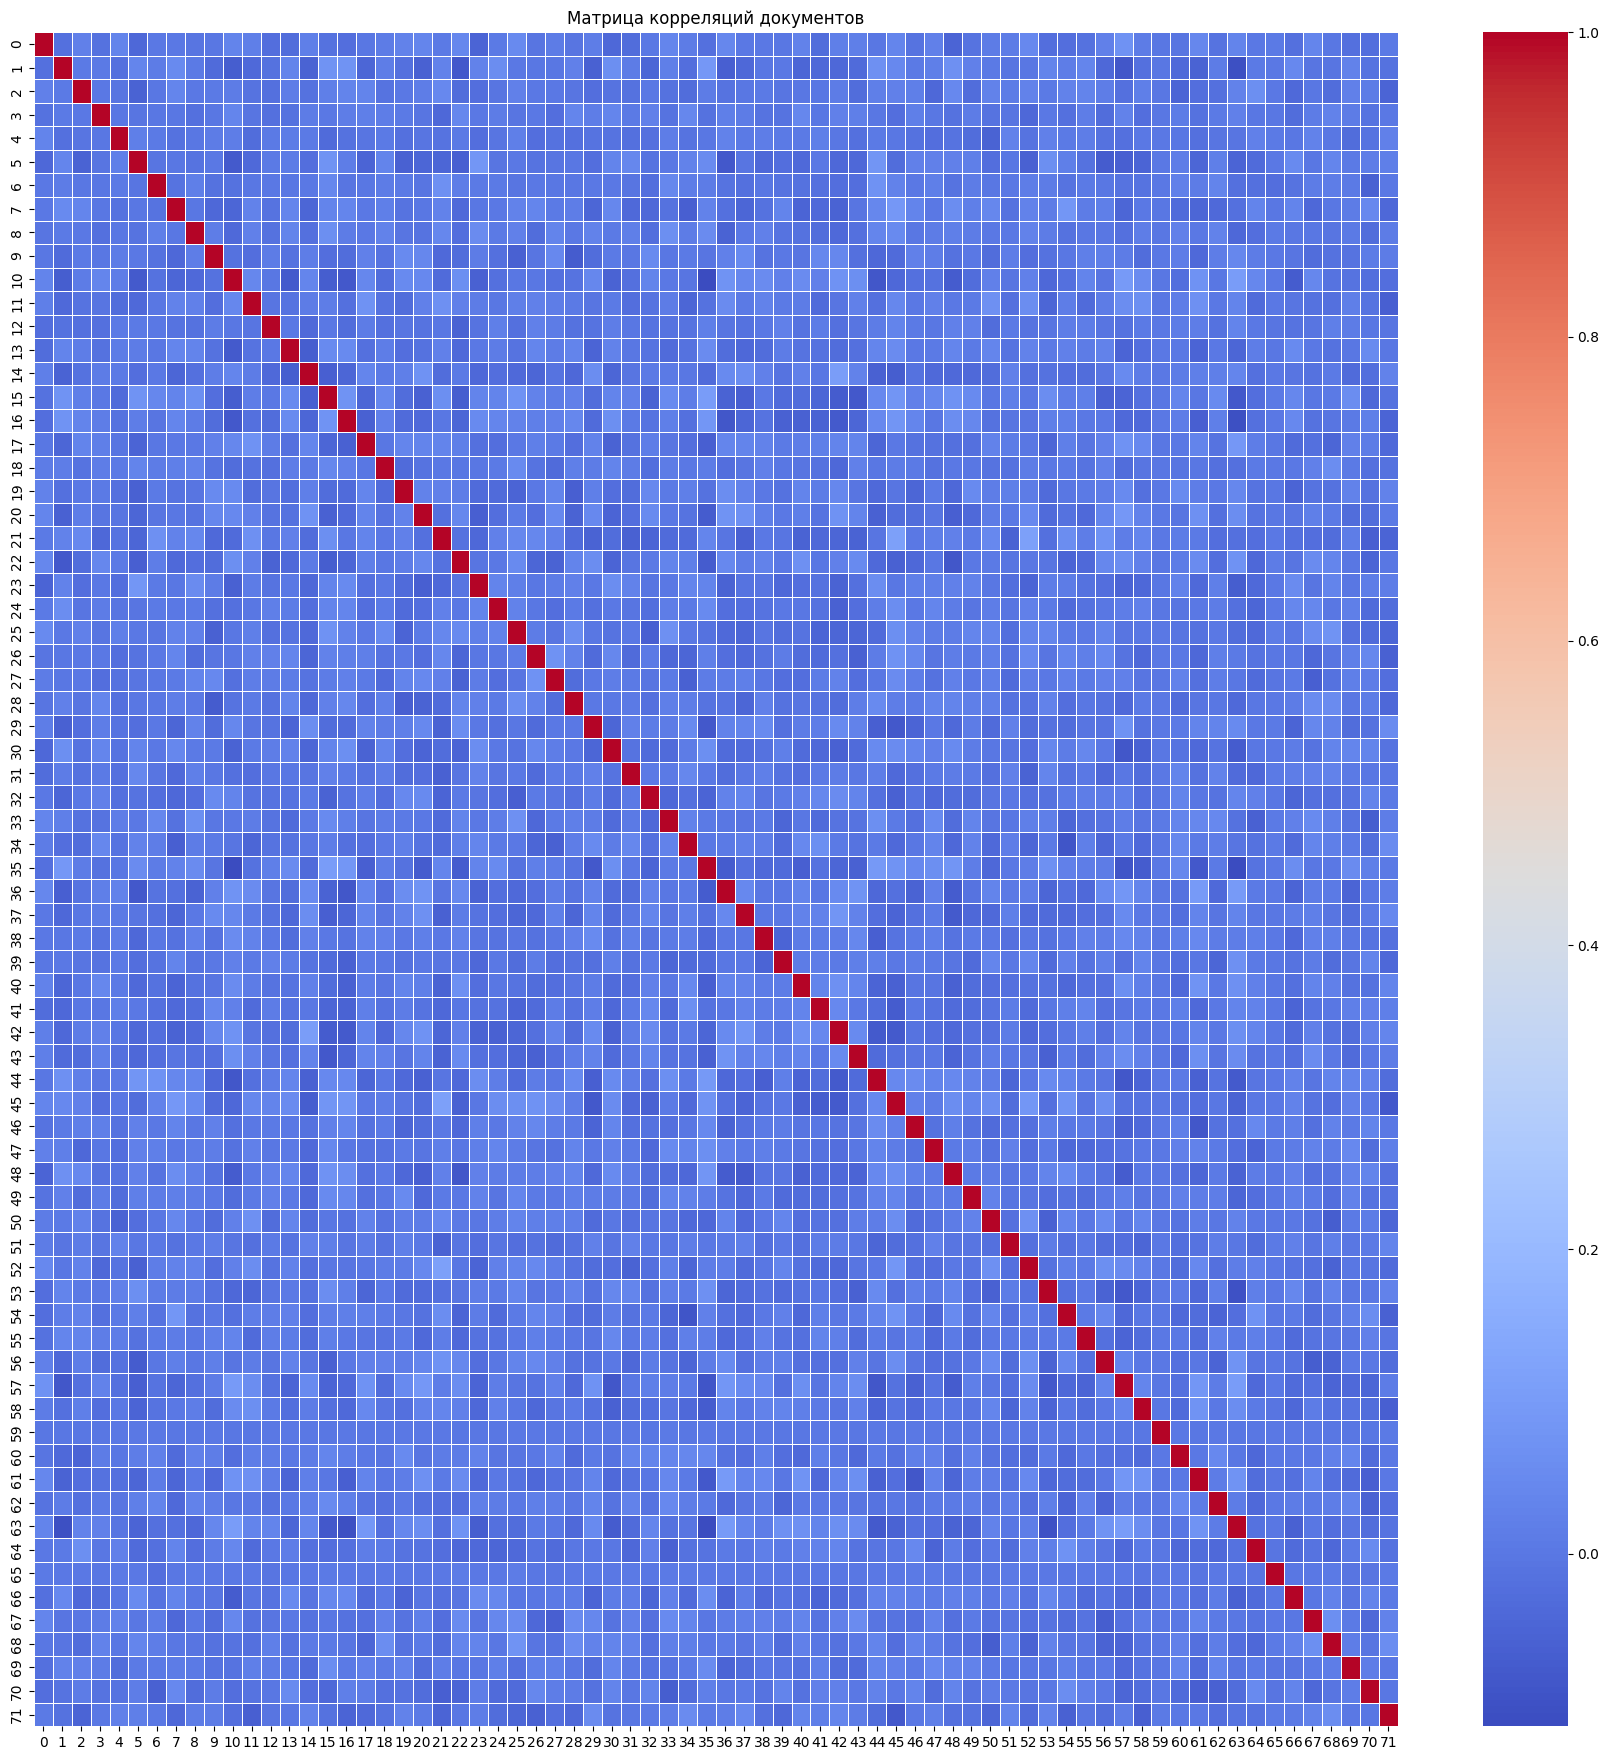

In [32]:
plt.figure(figsize=(22, 22))
sns.heatmap(docs.drop('Id', axis=1)\
            .corr(method='spearman'), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций документов')
plt.show()

**Итого**: мультиколлинеарность в документа

**Вывод**: проведён мультикорреляционный анализ, мультиколлинеарность признаков не обнаружена.

## Построение полного перебора

В качестве baseline алгоритма выберем полный перебор. Для построения базовых индексов используем евклидово, манхэтонское и косинусное расстояние. В дальнейшем есть смысл строить индексы с учётом лучшего гиперпараметра расстояния.

### Поработаем с данными
Масштабируем эмбеддинги.

In [33]:
scaler = StandardScaler()

docs_embeddings_cols = docs.select_dtypes(include=['float64', 'int64']).columns

docs[docs_embeddings_cols] = scaler.fit_transform(docs[docs_embeddings_cols])

In [34]:
docs.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,1.697621,1.472172,1.611622,0.720164,0.988042,2.405616,0.194131,-1.212793,0.743583,...,0.234670,-0.087623,1.565097,-0.390192,-0.449806,1.496933,-1.942992,1.903408,-0.717062,0.542687
1,2710972-base,0.531864,-0.636876,0.644767,0.507710,-0.244876,0.041579,-0.639277,-2.322743,-2.165328,...,-0.982878,-0.426557,-0.400421,-1.255531,-0.034788,-0.264126,-1.375463,0.833939,0.654040,-0.603929
2,1371460-base,0.027962,-1.731076,-0.097864,-0.573093,-0.311694,-0.348683,1.364039,0.923693,0.107585,...,0.664564,0.281125,0.528025,-0.572881,0.042909,2.137318,-0.094968,-0.182840,-0.811935,0.590122
3,3438601-base,-0.774326,1.478130,-0.042061,-0.579635,-0.684767,0.813675,1.101580,0.282878,-0.043363,...,-0.289519,-3.184920,0.167479,-1.712450,0.647074,-0.038422,0.835415,1.137340,-1.257242,-0.642624
4,422798-base,0.466312,0.654216,0.114117,-0.763467,-1.310466,-0.315526,-0.909476,0.697415,-0.209088,...,1.609918,0.705774,0.118264,1.648793,0.920182,-1.209474,-2.182348,0.859637,-0.717062,1.115495


In [35]:
train_embeddings_cols = train_queries.select_dtypes(include=['float64', 'int64']).columns

train_queries[train_embeddings_cols] = scaler.transform(train_queries[train_embeddings_cols])

validation_queries[train_embeddings_cols] = scaler.transform(validation_queries[train_embeddings_cols])

In [36]:
train_queries.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,109249-query,2.496951,-1.000634,-0.942940,1.726693,1.721999,0.176596,-1.345721,-1.488714,-0.491344,...,-2.001441,-0.316943,1.211982,0.214202,0.050502,-1.026331,1.552824,0.050505,0.019996,66971-base
1,34137-query,0.169656,0.008002,0.929057,-1.831770,-1.178061,0.684081,1.241207,1.706144,0.898624,...,0.733644,0.820137,-0.262520,-0.649446,-0.931181,-1.056450,-0.932695,-0.582763,-0.979007,1433819-base
2,136121-query,0.422955,-1.676494,-1.078852,-0.778567,0.066021,0.655808,1.015038,-0.704147,0.178519,...,-1.344310,1.496206,-0.956541,-2.224317,-0.219501,-0.194717,0.724604,-0.717062,-0.650610,290133-base
3,105191-query,1.190763,-0.602486,-0.060720,-0.122460,0.025388,-0.175221,0.251592,-0.828231,-0.660188,...,-0.402050,-0.101484,1.675824,1.149220,-1.036142,2.593690,0.342547,-0.717062,-1.103878,1270048-base
4,63983-query,1.345414,0.192056,-1.251213,1.687351,0.493224,1.045021,-1.345721,-0.188862,-0.658366,...,-0.672498,-1.309014,0.283298,-0.696393,0.322429,1.432688,-0.204475,1.677978,0.332643,168591-base


Извлечём метки (Id) и сами эмбеддинги.

In [37]:
# Метки и эмбедиинги документов
docs_id = docs['Id'].values
docs_embeddings = docs.drop(columns=['Id']).values.astype('float')

# Метки и эмбедиинги тренировочных запросов
train_query_id = train_queries['Id'].values
train_embeddings = train_queries.drop(columns=['Id', 'Target']).values.astype('float')
train_labels = train_queries['Target'].values

# Метки и эмбеддингм валидационных запросов
valid_query_id = validation_queries['Id'].values
valid_embeddings = validation_queries.drop(columns=['Id']).values.astype('float')
valid_labels = validation_answer['Expected'].values

### Построим индекс, хранящий евклидово расстояние

In [38]:
dims = docs_embeddings.shape[1]  # Размерность признаков

In [39]:
index_eclidean = faiss.IndexFlat(dims, faiss.METRIC_L2)

Для полного перебора индекс не нужно настраивать (обучать), достаточно лишь передать эмбеддинги документов в индекс. Убедиться в это можно, вызвав метод is_trained.

In [40]:
index_eclidean.is_trained

True

Передадим эмбеддинги документов.

In [41]:
start_time = time.time()

index_eclidean.add(docs_embeddings)

end_time = time.time()
eclidean_add_time = round(end_time - start_time, 2)
eclidean_add_time

0.18

Выполним тренировочные запросы и найдём 5 ближайших ссседей. Оценим метрику accuracy@5 на тренировочных данных.

In [42]:
start_time = time.time()

candidate_number = 5 
D, I = index_eclidean.search(train_embeddings, candidate_number)

end_time = time.time()
eclidean_search_time = round(end_time - start_time, 2)
eclidean_search_time

10.11

In [43]:
acc = 0
for target, el in zip(train_labels, I):
    acc += int(target in [docs_id[r] for r in el])

eclidean_accuracy = round((acc / len(I))*100, 2)
print(f'Accuracy@{candidate_number} на тренировочных запросах = {eclidean_accuracy}%')

Accuracy@5 на тренировочных запросах = 76.55%


**Итого:** Метрика accuracy@5 на тренировочных запросах составила 76.55%.

### Построим индекс, хранящий манхэттенское расстояние

In [44]:
index_manhattan = faiss.IndexFlat(dims, faiss.METRIC_L1) # инициализация индекса

In [45]:
start_time = time.time()

index_manhattan.add(docs_embeddings) # добавление эмбеддингов в индекс

end_time = time.time()
manhattan_add_time = round(end_time - start_time, 2)
manhattan_add_time

0.18

In [46]:
start_time = time.time()

D, I = index_manhattan.search(train_embeddings, candidate_number) # поиск по тренировочным запросам

end_time = time.time()
manhattan_search_time = round(end_time - start_time, 2)
manhattan_search_time

35.01

Посчитаем accuracy@5 на тренировочных запросах.

In [47]:
acc = 0
for target, el in zip(train_labels, I):
    acc += int(target in [docs_id[r] for r in el])

manhattan_accuracy = round((acc / len(I))*100, 2)    
print(f'Accuracy@{candidate_number} на тренировочных запросах = {manhattan_accuracy}%')

Accuracy@5 на тренировочных запросах = 78.67%


**Итого**: индекс с манхэттенским расстоянием показал accuracy@5, равным 78.67%.

### Построим индекс, хранящий косинусное расстояние.

In [48]:
index_cosine = faiss.IndexFlat(dims, faiss.METRIC_INNER_PRODUCT) # инициализация индекса

In [49]:
start_time = time.time()

index_cosine.add(docs_embeddings) # добавление эмбеддингов в индекс

end_time = time.time()
cosine_add_time = round(end_time - start_time, 2)
cosine_add_time

0.18

In [50]:
start_time = time.time()

D, I = index_cosine.search(train_embeddings, candidate_number) # поиск по тренировочным запросам

end_time = time.time()
cosine_search_time = round(end_time - start_time, 2)
cosine_search_time

9.99

Посчитаем accuracy@5 на тренировочных запросах.

In [51]:
acc = 0
for target, el in zip(train_labels, I):
    acc += int(target in [docs_id[r] for r in el])

cosine_accuracy = round((acc / len(I))*100, 2)    
print(f'Accuracy@{candidate_number} на тренировочных запросах = {cosine_accuracy}%')

Accuracy@5 на тренировочных запросах = 74.87%


**Итого:** Accuracy@5 составила 74.87%.

### Сравнение базовых индексов
Сравним использованные ваше алгоритмы и решим, какой будем использовать, исходя из параметров времени добавления эмбеддингов, времени поиска и метрики accuracy@5.

In [52]:
add_time = [eclidean_add_time, manhattan_add_time, cosine_add_time]
search_time = [eclidean_search_time, manhattan_search_time, cosine_search_time]
accuracy = [eclidean_accuracy, manhattan_accuracy, cosine_accuracy]

data = {'add_time': add_time, 'search_time': search_time, 'accuracy@5': accuracy}

contrast_index = pd.DataFrame(data, index=['eclidean', 'manhattan', 'cosine'])
contrast_index

,add_time,search_time,accuracy@5
eclidean,0.18,10.11,76.55
manhattan,0.18,35.01,78.67
cosine,0.18,9.99,74.87


**Итого**: Самая большая метрика accuracy@5 достигается при использовании манхэтонского расстояния. Однако использовать этот способ расчёта нецелесобразно из-за слишком долгого поиска. Вместо этого будем использовать евклидово расстояние, поскольку так объекты ищутся за адекватное время (10 секунд).

## Построение IFV (inverted file index)

Из анализа выше, было определено, что евклидово расстояние в построении индекса является оптимальным.

### Построим IFV. Переберём гиперпараметр nlist (количество кластеров) и найдём лучшую модель.

In [53]:
cl = [] # перебираемые кластеры
train_time = [] # время обучения индекса
search_time = [] # время поиска
accuracy = [] # accuracy@5

In [54]:
quantizer = faiss.IndexFlatL2(dims)  # Используем L2 (евклидово) расстояние, как самое оптимальное 

for clusters in range(100, 401, 25):
    nlist = clusters  # Количество кластеров (ячеек Вороного)
    
    idx_ivf = faiss.IndexIVFFlat(quantizer, dims, nlist)  # Строим inverted file index
    
    start_time = time.time()
    idx_ivf.train(docs_embeddings)  # В отличие от полного перебора, IFV требует тренировки индекса
    idx_ivf.add(docs_embeddings)  # Добавление векторов-документов в индекс
    end_time = time.time()
    tr_time = round(end_time - start_time, 2)
    
    # Проведём поиск для тренировочного набора
    start_time = time.time()
    D, I = idx_ivf.search(train_embeddings, candidate_number)  # D-расстояния, I-индексы ближайших соседей (из docs)
    end_time = time.time()
    sh_time = round(end_time - start_time, 2)
    
    # Оценим результат по метрике accuracy@5
    acc = 0
    for target, el in zip(train_labels, I):
        acc += int(target in [docs_id[r] for r in el])
    acc = round((acc / len(I))*100, 2)
    
    # Сохраним результаты для дальнейшего исследования
    cl.append(nlist)
    train_time.append(tr_time)
    search_time.append(sh_time)
    accuracy.append(acc)

### Оценка результата

In [55]:
data = {'nlist': cl, 'train_time': train_time, 'search_time': search_time,'accuracy@5': accuracy}

ifv_df = pd.DataFrame(data)

In [56]:
ifv_df

,nlist,train_time,search_time,accuracy@5
0,100,0.60,0.41,61.43
1,125,0.70,0.35,61.67
2,150,0.80,0.29,61.55
3,175,1.01,0.25,61.00
4,200,1.02,0.21,61.78
5,225,1.20,0.20,60.53
6,250,1.41,0.19,61.05
7,275,1.65,0.17,60.77
8,300,1.81,0.15,61.09
9,325,2.06,0.14,61.15


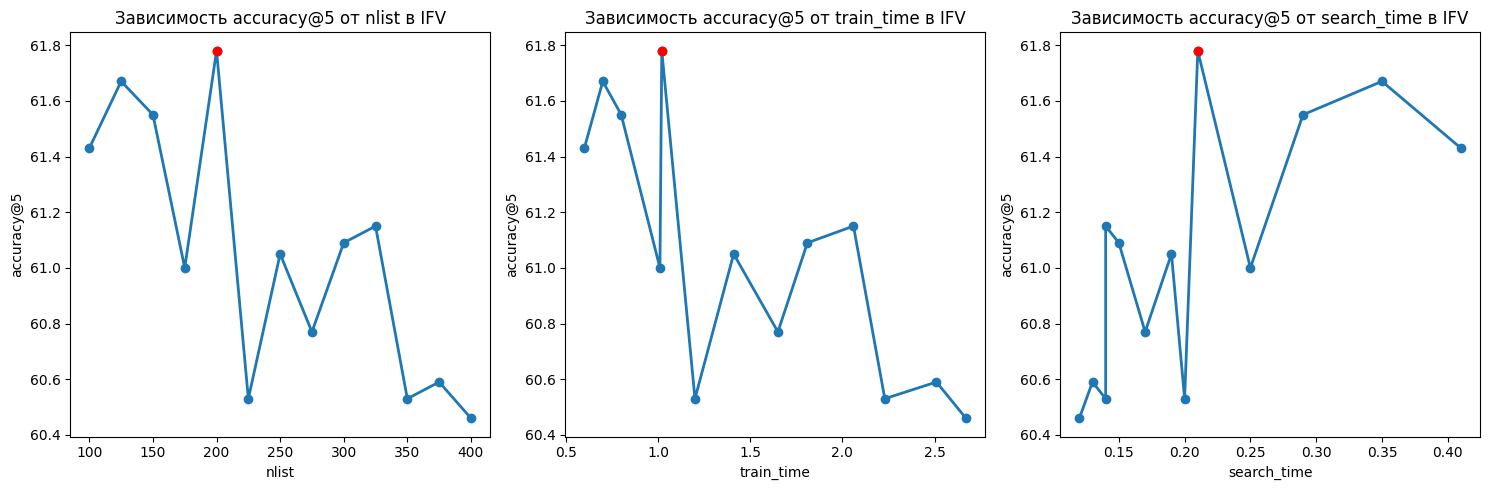

In [57]:
index_plot(ifv_df, 'IFV')

**Итого**: при самом большом значении accuracy@5 (красная точка) не самое большое время обучения и время поиска. Количество кластеров так же не самое большое.

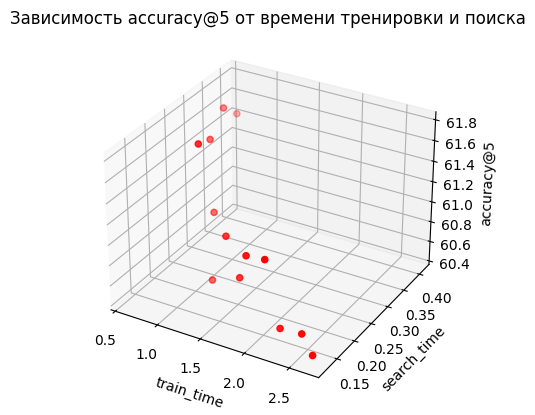

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ifv_df['train_time'], ifv_df['search_time'], ifv_df['accuracy@5'], c='r', marker='o')
ax.set_xlabel('train_time')
ax.set_ylabel('search_time')
ax.set_zlabel('accuracy@5')
plt.title('Зависимость accuracy@5 от времени тренировки и поиска')
plt.show()

Найдём тот самый лучший гиперпараметр nlist.

In [59]:
ifv_df.iloc[ifv_df['accuracy@5'].idxmax()]

nlist          200.00
train_time       1.02
search_time      0.21
accuracy@5      61.78
Name: 4, dtype: float64

**Итого:** максимум accuracy@5 в IFV достигается при nlist=200.

**Вывод**: хотя и время поиска, в отличие от полного перебора, действительно сократилось в разы, результат метрики пока не очень впечатляет - 61.78%. Постараемся его улучшить более продвинутой техникой.

## Построение HNSW (Hierarchical Navigable Small World)

### Построим HNSW. Переберём гиперпараметр M (количество соседей для вершины) и найдём лучшую модель.

In [60]:
m = [] # количество соседей для каждой вершины
add_time = [] # время добавления векторов
search_time = [] # время поиска
accuracy = [] # accuracy@5

In [61]:
for neighbors in [pow(2, i) for i in range(1, 8)]:
    M = neighbors
    hnsw_index = faiss.IndexHNSWFlat(dims, M, faiss.METRIC_L2) # инициализируем HNSW индекс с евклидовым расстоянием
    
    start_time = time.time()
    hnsw_index.add(docs_embeddings) # HNSW не требует обучения, достаточно лишь добавить векторы
    end_time = time.time()
    hnsw_add_time = round(end_time-start_time, 2)
    
    start_time = time.time()
    D, I = hnsw_index.search(train_embeddings, candidate_number) # выполнения тренировочных запросов
    end_time = time.time()
    hnsw_search_time = round(end_time-start_time, 2)
    
    acc = 0
    for target, el in zip(train_labels, I):
        acc += int(target in [docs_id[r] for r in el])
    acc = round((acc / len(I))*100, 2)
    
    m.append(M)
    add_time.append(hnsw_add_time)
    search_time.append(hnsw_search_time)
    accuracy.append(acc)

### Оценка результата

In [62]:
data = {'M': m, 'add_time': add_time, 'search_time': search_time,'accuracy@5': accuracy}

hnsw_df = pd.DataFrame(data)

In [63]:
hnsw_df

,M,add_time,search_time,accuracy@5
0,2,3.87,0.05,2.58
1,4,6.69,0.08,12.14
2,8,8.88,0.12,32.54
3,16,11.10,0.17,49.79
4,32,45.15,0.30,66.03
5,64,81.12,0.42,70.50
6,128,119.52,0.58,72.76


**Итого:** значение метрики напрямую зависит от количества вершин-соседей - чем количество соседей больше, тем больше accuracy@5. Также заметим, что чем больше количество вершин, тем дольше выполняется поиск.

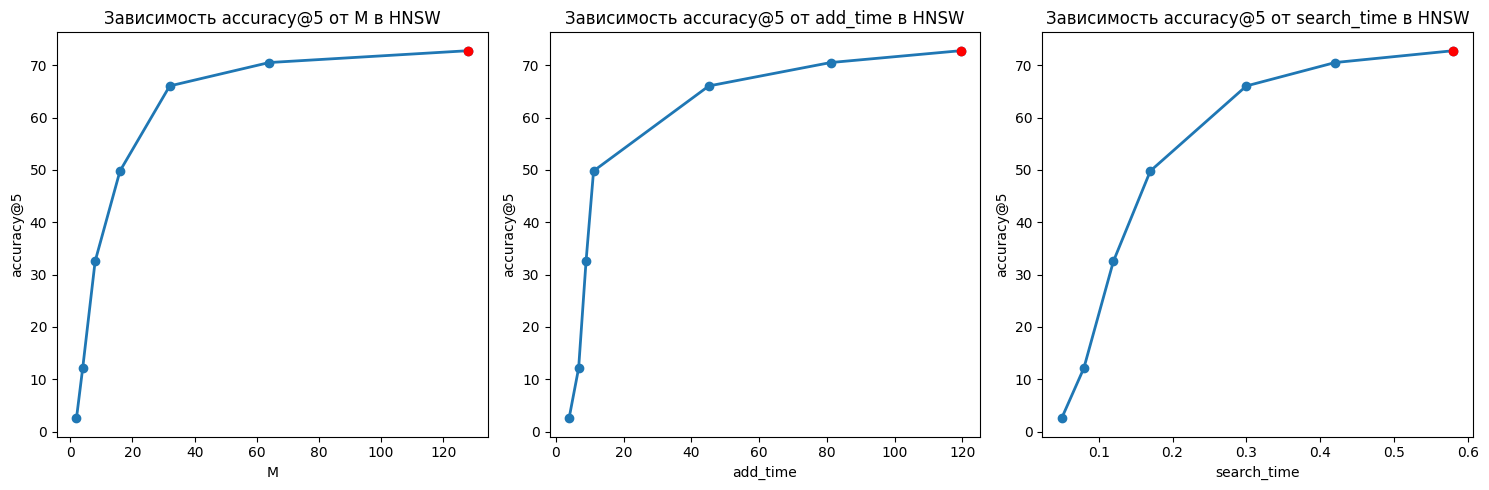

In [64]:
index_plot(hnsw_df, 'HNSW')

**Итого**: максимальное значение accuracy@5 удалось достичь при максимальном гиперпараметре M. С увеличением M росло время добавления векторов и время поиска. 

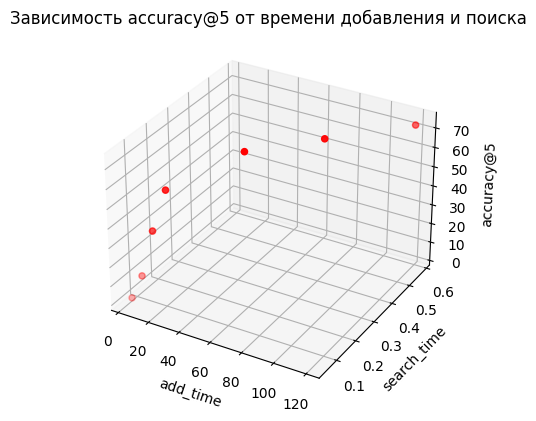

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hnsw_df['add_time'], hnsw_df['search_time'], hnsw_df['accuracy@5'], c='r', marker='o')
ax.set_xlabel('add_time')
ax.set_ylabel('search_time')
ax.set_zlabel('accuracy@5')
plt.title('Зависимость accuracy@5 от времени добавления и поиска')
plt.show()

**Итого:** максимум accuracy@5 в HNSW достигается при M=128.

**Вывод:** несмотря на то, что время поиска значительно больше, чем в IFV, результат метрики получился гораздо лучше - 72.76%.

## Оценка результата

Лучше всего себя показал алгоритм HNSW. За адекватно время, метрика accuracy@5 достигла ... . Используем этот алогритм для подсчёта метрики на валидационных данных.

In [66]:
hnsw_index = faiss.IndexHNSWFlat(dims, 128, faiss.METRIC_L2)

hnsw_index.add(docs_embeddings)

D, I = hnsw_index.search(valid_embeddings, candidate_number)

acc = 0
for target, el in zip(valid_labels, I):
    acc += int(target in [docs_id[r] for r in el])
acc = round((acc / len(I))*100, 2)
print(f'Метрика accuracy@5 на валидационныз данных: {acc}')

Метрика accuracy@5 на валидационныз данных: 71.75


**Итого**: метрика на валидационных данных составила accuracy@5 71.75%

## Общий вывод

В ходе работы была построена модель матчинга товаров, которая сравнивала три различные модели: прямой перебор, модель IFV и HNSW. После проведения экспериментов и анализа результатов, лучшей моделью оказалась HNSW, которая достигла наилучших результатов в разумное время.

Работа включала в себя следующие этапы:
1. Загрузка данных: В начале работы были загружены данные, необходимые для построения модели матчинга товаров. Загружены необходимые библиотеки, созданы функции.

2. EDA: Построены гистограммы и ящики с усами всех признаков (координат эмбеддингов), выявлено, что векторы документов во многом похожи с  векоторами запросов  

3. Корреляционный анализ: Распределения признаков проверены на нормальность, с учётом этой информации был выбран нужный коэффициент корреляции (Спирмерна) и построены тепловые карты признаков. Мультиколлинеарность не обнаружена.

4. Построение моделей: Были построены три различные модели для сравнения и выбора наилучшей. Это включало модель прямого перебора с различными вычислениями расстояний. На основе анализов результатов полного перебора, было решено использовать евклидово расстояние для дальнейшего построения моделей. Далее были построены модель IFV и модель HNSW. Лучше всего себя показала HNSW, метрика accuracy@5 на валидационных данных составила 72,76%.

5. Эксперименты и анализ результатов: После построения моделей были проведены эксперименты для сравнения и анализа их производительности. В модели IFV найден лучший гиперпараметр nlist (число кластеров для разбиения), а для HNSW гиперпараметр M (число соседей для каждой вершины).

6. Выбор лучшей модели: На основе результатов экспериментов была выбрана наилучшая модель для задачи матчинга товаров. В данном случае, лучшей моделью оказалась HNSW, обеспечившая наилучшие результаты за разумное время.